In [6]:
# Make the following code support python2 and python3
from __future__ import division, print_function, unicode_literals
# in this model, Python= 3.8 XGBoost = 1.73 
# Check if the version of python is 3.8 and above
import sys
assert sys.version_info >= (3, 8)
# Check to see if sklearn is version 1.0 and above
import sklearn
assert sklearn.__version__ >= "1.0"
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib import cm
import scipy.stats as stats
from matplotlib.colors import Normalize
from scipy.interpolate import interpn
import matplotlib as mpl
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
# save model
import pickle
plt.style.use('fast')
#plt.grid(False)
# show off all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# The result obtained after each run is the same as that of this notebook
np.random.seed(42)

# Setting the route to save the image
PROJECT_ROOT_DIR = "."
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGE_PATH, exist_ok=True)

# Setting the route to save the model
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
os.makedirs(MODEL_PATH, exist_ok=True)

# Setting the route to read the data set
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets")


def save_fig(fig_id, tight_layout=True):
    '''
    Run to save automatic pictures
    
    :param fig_id: image name
    '''
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

def error_less_than_five(estimated_values, true_values, rmse):
    """
    Calculate the percentage of data points with an error strictly less than RMSE.

    :param estimated_values: A list of estimated or predicted values.
    :param true_values: A list of actual or true values.
    :return: The percentage of data points where the error is strictly less than RMSE.
    """
    if len(estimated_values) != len(true_values):
        raise ValueError("The lists of estimated and true values must have the same length.")

    # Calculate the number of data points where the error is less than RMSE
    count = 0
    for estimated, true in zip(estimated_values, true_values):
        error = abs(estimated - true)
        if error < rmse:  # Checking if the error is strictly less than RMSE
            count += 1

    # Calculate the percentage of such data points
    percentage = (count / len(true_values)) * 100
    return percentage




# suppress the warning caused by sklearn
import warnings

warnings.filterwarnings('ignore')


In [9]:
df = pd.read_excel("datasets/Training_model_1.xlsx",'Data For Training (3)')
df.head()
df  = df.drop(['CITATIONS',	'LATITUDE',	'LONGITUDE','MNO(WT%)',	'SAMPLE NAME','(La/Yb)n','Rb/Sr'], axis = 1)
print(df.shape, df.columns)
df.info()

(2744, 35) Index(['Label', 'crust_thickness', 'SIO2(WT%)', 'TIO2(WT%)', 'AL2O3(WT%)',
       'FEOT(WT%)', 'CAO(WT%)', 'MGO(WT%)', 'K2O(WT%)', 'NA2O(WT%)',
       'P2O5(WT%)', 'CR(PPM)', 'NI(PPM)', 'RB(PPM)', 'SR(PPM)', 'Y(PPM)',
       'ZR(PPM)', 'NB(PPM)', 'BA(PPM)', 'LA(PPM)', 'CE(PPM)', 'PR(PPM)',
       'ND(PPM)', 'SM(PPM)', 'EU(PPM)', 'GD(PPM)', 'TB(PPM)', 'DY(PPM)',
       'ER(PPM)', 'YB(PPM)', 'LU(PPM)', 'HF(PPM)', 'TH(PPM)', 'Ln((La/Yb)n)',
       'Sr/Y'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2744 entries, 0 to 2743
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Label            2744 non-null   int64  
 1   crust_thickness  2744 non-null   float64
 2   SIO2(WT%)        2744 non-null   float64
 3   TIO2(WT%)        2744 non-null   float64
 4   AL2O3(WT%)       2744 non-null   float64
 5   FEOT(WT%)        2744 non-null   float64
 6   CAO(WT%)         2744 non-nul

In [10]:
#count the .percentage of Nan
df.isnull().sum().sum() /(df.shape[0]* df.shape[1])

0.05514369012911287

# Corr Plot

In [11]:
df2 = df.drop('Label', axis = 1)
df2.head()

,crust_thickness,SIO2(WT%),TIO2(WT%),AL2O3(WT%),FEOT(WT%),CAO(WT%),MGO(WT%),K2O(WT%),NA2O(WT%),P2O5(WT%),CR(PPM),NI(PPM),RB(PPM),SR(PPM),Y(PPM),ZR(PPM),NB(PPM),BA(PPM),LA(PPM),CE(PPM),PR(PPM),ND(PPM),SM(PPM),EU(PPM),GD(PPM),TB(PPM),DY(PPM),ER(PPM),YB(PPM),LU(PPM),HF(PPM),TH(PPM),Ln((La/Yb)n),Sr/Y
0,25.570,59.702065,1.458461,15.862021,7.031831,4.653029,2.020201,1.122293,6.015838,0.456267,1.1964,1.3958,16.0,310.0,50.5479,335.989,11.1664,178.83454,20.482725,49.901815,6.997974,30.9,8.239798,2.461873,8.830307,1.507821,9.519362,5.387897,4.998533,0.783026,7.709839,2.73459,1.023782,6.132797
1,27.210,62.570000,1.210000,15.260000,6.450000,3.630000,1.240000,1.210000,6.440000,0.300000,9.0000,4.0000,21.0,260.0,66.0000,496.000,14.0000,200.00000,28.000000,61.500000,NaN,34.7,8.640000,2.360000,9.160000,NaN,9.740000,6.430000,6.120000,NaN,NaN,4.00000,1.133987,3.939394
2,32.375,64.360000,0.600000,16.540000,4.010000,4.930000,2.090000,2.040000,4.200000,0.240000,38.0000,NaN,57.0,470.0,8.0000,141.000,5.0000,449.00000,28.500000,58.800000,NaN,19.5,3.400000,1.400000,NaN,0.770000,NaN,NaN,1.200000,0.250000,4.100000,11.60000,2.780927,58.750000
3,32.375,62.350000,0.790000,16.610000,5.430000,5.710000,2.870000,2.090000,4.170000,0.230000,28.0000,19.0000,57.0,511.0,15.0000,149.000,10.0000,447.00000,29.600000,59.700000,NaN,20.0,4.000000,1.100000,NaN,0.660000,NaN,NaN,1.320000,0.220000,4.100000,10.40000,2.723487,34.066667
4,32.375,62.040000,0.790000,16.590000,5.460000,5.720000,2.910000,2.160000,4.110000,0.250000,26.0000,18.0000,63.0,463.0,16.0000,150.000,11.0000,444.00000,29.300000,60.100000,NaN,21.1,4.000000,1.100000,NaN,0.470000,NaN,NaN,1.540000,0.190000,4.600000,10.70000,2.559149,28.937500


<AxesSubplot:>

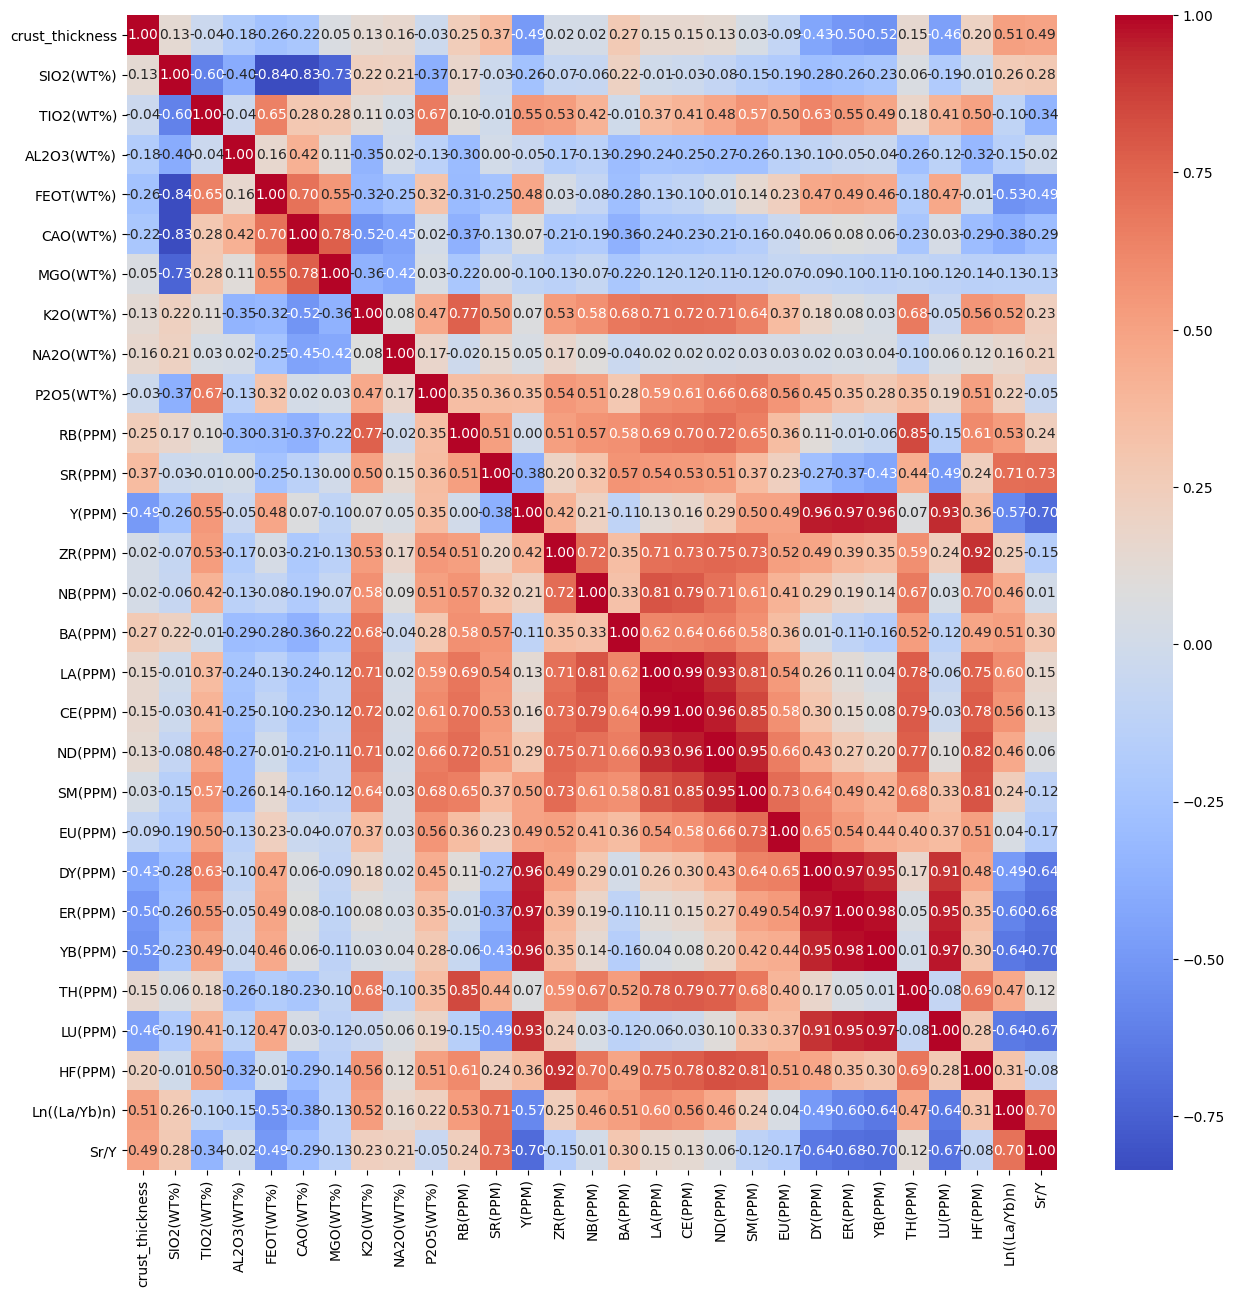

In [12]:
f, ax= plt.subplots(figsize = (15, 15))
df5=df2[['crust_thickness','SIO2(WT%)','TIO2(WT%)', 'AL2O3(WT%)','FEOT(WT%)', 'CAO(WT%)', 'MGO(WT%)', 'K2O(WT%)',
         'NA2O(WT%)','P2O5(WT%)','RB(PPM)',
         'SR(PPM)', 'Y(PPM)', 'ZR(PPM)', 'NB(PPM)', 'BA(PPM)', 'LA(PPM)',
         'CE(PPM)', 'ND(PPM)', 'SM(PPM)', 'EU(PPM)',  'DY(PPM)',
         'ER(PPM)', 'YB(PPM)', 'TH(PPM)','LU(PPM)','HF(PPM)','Ln((La/Yb)n)','Sr/Y']]
sns.heatmap(df5.corr(), cmap='coolwarm', annot=True, fmt ='.2f')

# Split Train and Test data

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
def train_test_sp(data, target, test_size):
    """
    based sklearn.model_selection.StratifiedShuffleSplit
    param data: data
    param target: the label 
    param test_size: float 0-1
    """
    splitned = StratifiedShuffleSplit(n_splits= 1, test_size = test_size, random_state = 2020)
    for train_index, test_index in splitned.split(data, data[target]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    return  strat_train_set, strat_test_set

# Pretreatment (-1 without pretreatment)
from sklearn import preprocessing
def data_process(X,choice):
    if choice==0:
        X=preprocessing.RobustScaler().fit_transform(X)
    elif choice==1:
        X=preprocessing.MinMaxScaler().fit_transform(X)
    elif choice==2:
        X=preprocessing.StandardScaler().fit_transform(X)
    elif choice==3:
        X=preprocessing.PowerTransformer().fit_transform(X)
    elif choice==-1:
        X=X
    return X


In [15]:
df.reset_index(drop=True, inplace=True)
train_set , test_set = train_test_sp(df,'Label',0.2)

X_train = train_set.drop(columns=['crust_thickness','Label'])
X_test =  test_set.drop(columns=['crust_thickness','Label'])
y_train = train_set['crust_thickness']
y_test = test_set['crust_thickness']
title = X_test
title2 = X_train

In [16]:
X_train = pd.DataFrame(data_process(np.array(X_train), 3))
X_test = pd.DataFrame(data_process(np.array(X_test), 3))

# XGboost

In [17]:
import xgboost
xgb = xgboost.XGBRegressor()

In [18]:
# colsample_bytree = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# boost_params = ["gblinear", "gbtree"]
# base_score =np.arange(0,0.5,0.1)
# max_depth = [2,3,4,5,6,7,8,9]
# learning_rate=np.arange(0.05,0.2,0.01)
# min_child_weight = np.arange(40,300,50)
# n_estimators = [100,150,200,250,300,350,400,500,600]
# 
# 
# params = {
#     "colsample_bytree":colsample_bytree,
#     "boost_params":boost_params,
#     "max_depth":max_depth,
#     "learning_rate":learning_rate,
#     "min_child_weight":min_child_weight,
#     "n_estimators":n_estimators,
#     "base_score":base_score
# }
# 
# #xgb_opt = GridSearchCV(xgb, param_grid = params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1 )
# xgb_opt = RandomizedSearchCV(xgb, param_distributions=params, cv=5, scoring='r2', n_jobs=-1, n_iter=200, random_state=2022)
# xgb_fit = xgb_opt.fit(X_train, y_train)

In [11]:
# xgb_opt.best_estimator_
#xgb_best_model = xgb_opt.best_estimator_

In [19]:
# cv_results = cv_results.sort_values('rank_test_score')
# cv_results

In [20]:
colsample_bytree = [0.5]
boost_params = ["gbtree"]
base_score =[0.3]
max_depth = [10]
learning_rate=[0.1]
min_child_weight = [100]
n_estimators = [250]

params = {
    "colsample_bytree":colsample_bytree,
    "boost_params":boost_params,
    "max_depth":max_depth,
    "learning_rate":learning_rate,
    "min_child_weight":min_child_weight,
    "n_estimators":n_estimators,
    "base_score":base_score
}

#xgb_opt = GridSearchCV(xgb, param_grid = params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1 )
xgb_opt = RandomizedSearchCV(xgb, param_distributions=params, cv=5, scoring='r2', n_jobs=-1, n_iter=200, random_state=2022)
xgb_fit = xgb_opt.fit(X_train, y_train)
cv_results=pd.DataFrame(xgb_fit.cv_results_)
cv_results

[09:54:51] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "boost_params" } are not used.



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_colsample_bytree,param_boost_params,param_base_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.452976,0.023992,0.008399,0.00049,250,100,10,0.1,0.5,gbtree,0.3,"{'n_estimators': 250, 'min_child_weight': 100,...",0.843346,0.838925,0.807543,0.845952,0.849383,0.83703,0.015134,1


In [57]:
xgb_reg = xgboost.XGBRegressor(base_score=0.3, boost_params='gbtree', booster=None,
                               callbacks=None, colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.5, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None, feature_types=None,
                               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10, max_leaves=None,
                               min_child_weight=100,  monotone_constraints=None,
                               n_estimators=250, n_jobs=None, num_parallel_tree=None,
                               predictor=None,)



# Save the trained model
with open('models/crust_thickness_xgboost_regression_model1.0.pkl', 'wb') as f:
    pickle.dump(xgb_reg.fit(X_train, y_train), f)


xgb_reg.fit(X_train, y_train).save_model('models/xgb_model1.json')

    

[11:24:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "boost_params" } are not used.

[11:24:09] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "boost_params" } are not used.



In [28]:
y_xgb = xgb_reg.fit(X_train, y_train).predict(X_test)
y_xgb_train = xgb_reg.fit(X_train, y_train).predict(X_train)

[09:59:13] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "boost_params" } are not used.

[09:59:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "boost_params" } are not used.



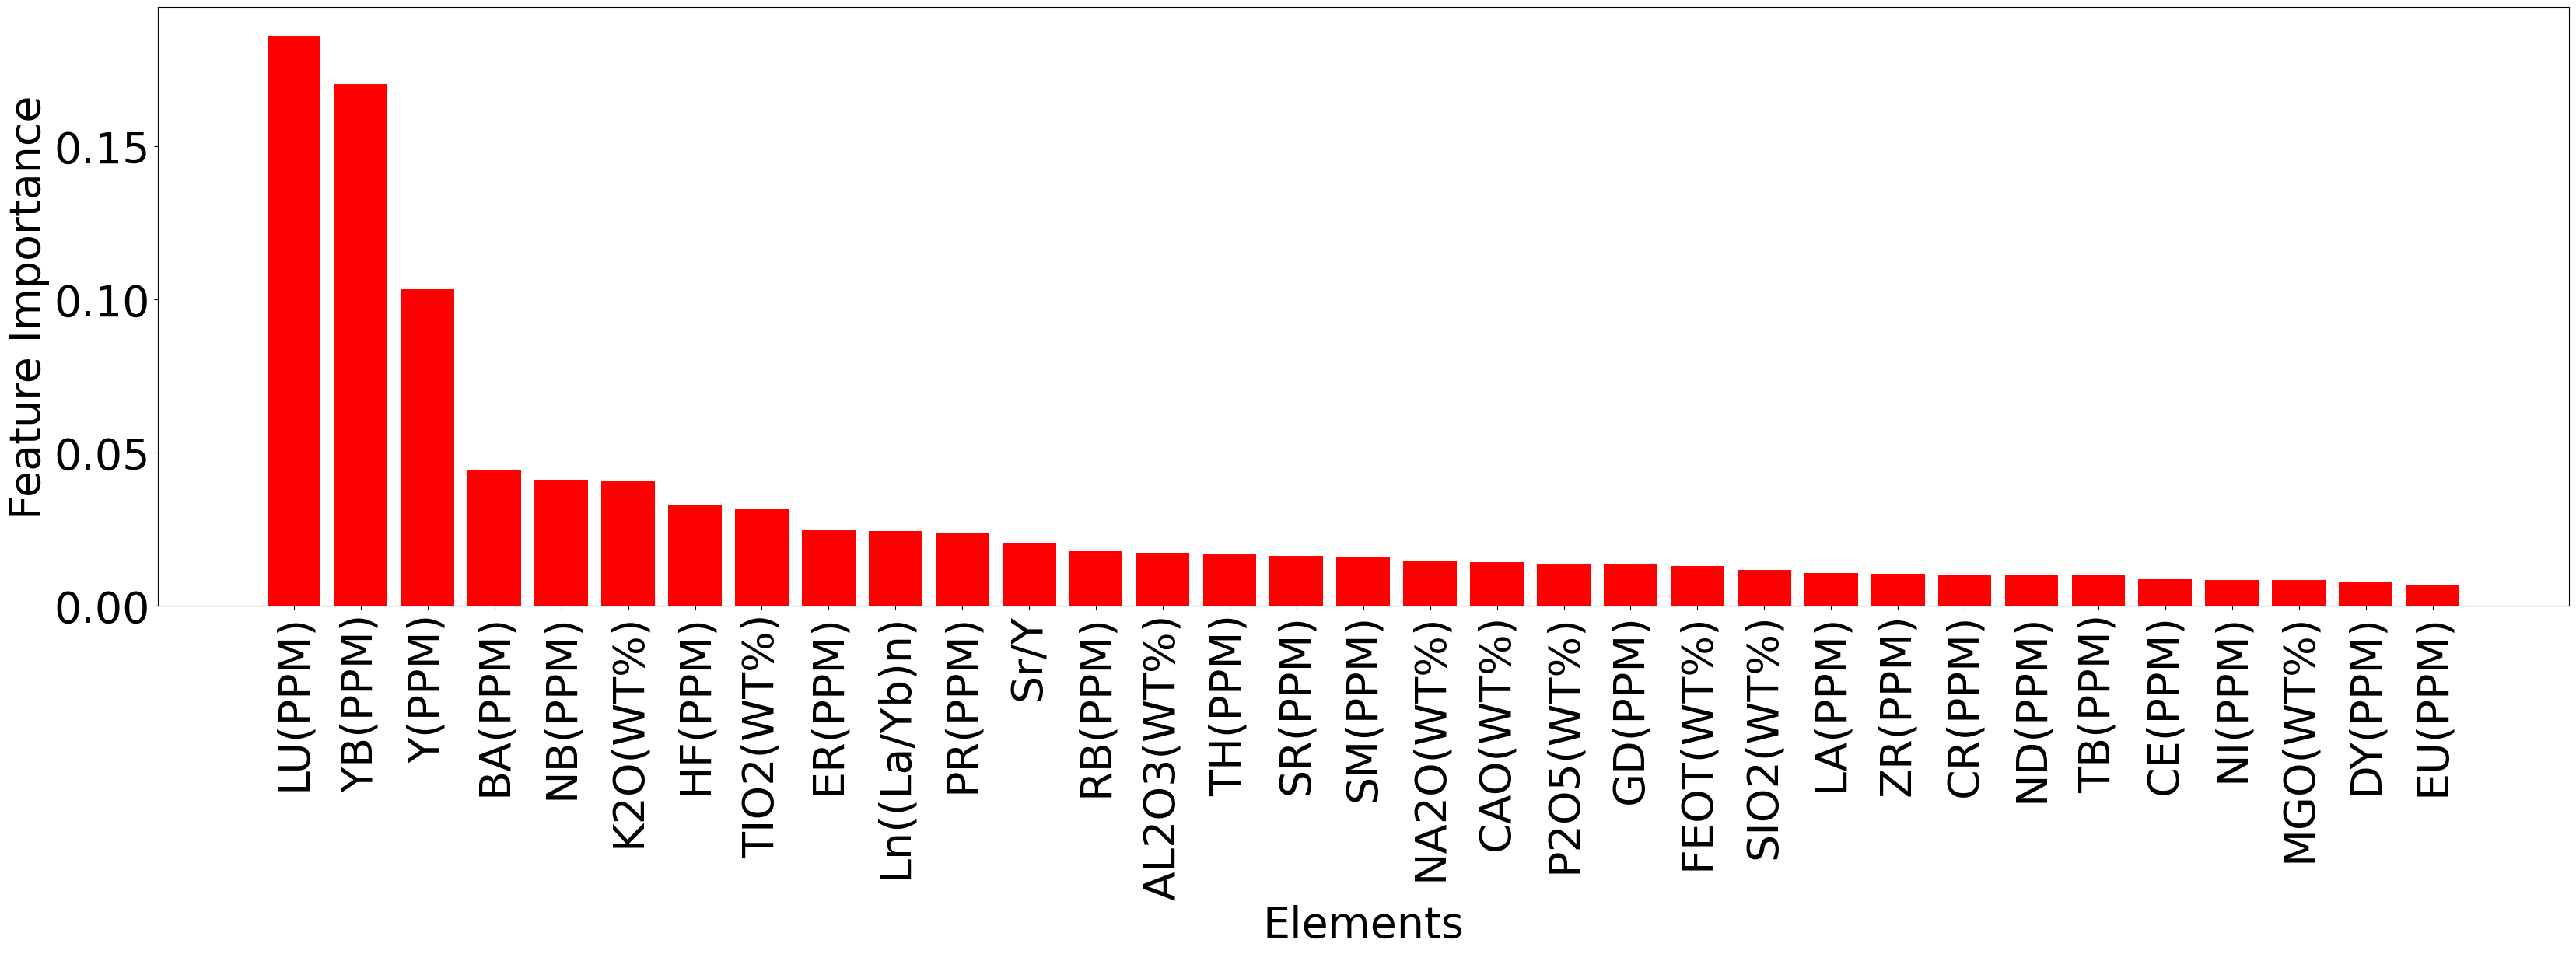

In [23]:
from pandas.core.frame import DataFrame
c={"feature" : title.columns,
   "importance" : xgb_reg.feature_importances_}#将列表a，b转换成字典
df_importance=DataFrame(c)#将字典转换成为数据框
df_importance.head(5)

c={"feature" : title.columns,
   "importance" : xgb_reg.feature_importances_}#将列表a，b转换成字典
df_importance=pd.DataFrame(c)#将字典转换成为数据框
df_importance = df_importance.sort_values('importance',ascending=False)
df_importance
plt.figure(figsize=(40,10))
# 柱状图显示xgBOOST预测的特征的权重
plt.bar(range(len(df_importance)), df_importance['importance'], tick_label=df_importance['feature'] , color = 'r' )
#save_fig("rnd_feature_importance")
plt.ylabel('Feature Importance', fontsize=40)
plt.xlabel('Elements', fontsize=40)
plt.xticks(rotation=90)
plt.tick_params(labelsize=40)
plt.grid(False)
#plt.savefig('images/feature importance.eps' ,format = 'eps')

The absolute error for the XGBOOST Model : 3.297535069019199
The mean squared error for the XGBOOST Model : 4.659396258628732
The R2-score for the XGBOOST Model : 0.8692888954652003


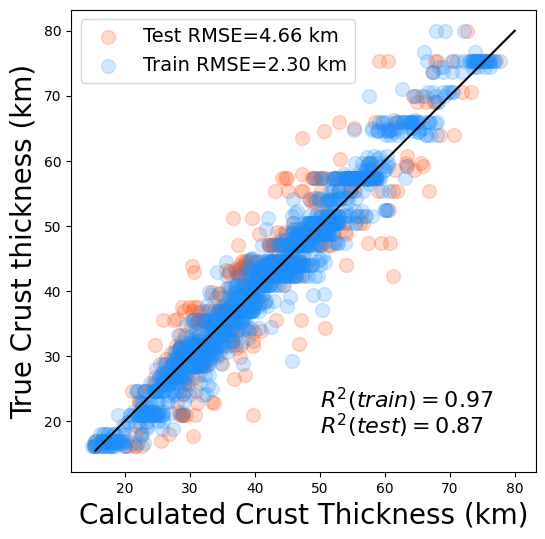

In [24]:
MAE = mean_absolute_error(y_test, y_xgb)
MSE = mean_squared_error(y_test, y_xgb)
R2_xg = r2_score(y_test, y_xgb)
RMSE = np.sqrt(MSE)

MAE2 = mean_absolute_error(y_train, y_xgb_train)
MSE2 = mean_squared_error(y_train, y_xgb_train)
R2_xg2 = r2_score(y_train, y_xgb_train)
RMSE2 = np.sqrt(MSE2)


print("The absolute error for the XGBOOST Model :", MAE)
print("The mean squared error for the XGBOOST Model :", RMSE)
print("The R2-score for the XGBOOST Model :", R2_xg)
plt.figure(figsize = (6,6))
#plt.scatter(y_test, y_xgb, color = 'brown')
#plt.scatter(y_train, y_xgb_train, color = 'lightyellow')
#plt.xlabel('True Test Values')
#plt.ylabel('Predictions from Model')

p1 = max(max(y_xgb), max(y_test))
p2 = min(min(y_xgb), min(y_test))
plt.plot([p1, p2], [p1, p2], 'black')
# plt.yscale([0,80])
# plt.xscale([0,80])
plt.ylabel('True Crust thickness (km)', fontsize=20)
plt.xlabel('Calculated Crust Thickness (km)', fontsize=20)
text_position=[50, 20]
plt.scatter( y_xgb, y_test,s = 100, marker="o", c = 'orangered' ,
             label="Test RMSE={:.2f} km".format(RMSE),alpha = 0.2)
plt.scatter( y_xgb_train,y_train,s = 100,  marker="o", c = 'dodgerblue',
             label="Train RMSE={:.2f} km".format(RMSE2),alpha = 0.2)

plt.legend(loc="upper left", fontsize=14)
plt.text(text_position[0], text_position[1]-2,
         r'$R^2(test)=${:.2f} '.format(R2_xg),
         fontdict={'size': 16, 'color': '#000000'})
plt.text(text_position[0], text_position[1]+2,
         r'$R^2(train)=${:.2f} '.format(R2_xg2),
         fontdict={'size': 16, 'color': '#000000'})
#plt.title('Xgboost model with Gangdese this study', fontsize=20)
y_test1 = y_test.values
plt.grid(False)
#plt.savefig('Train and test.eps' ,format = 'eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Percentage of data points with an error strictly less than RMSE: 75.41%


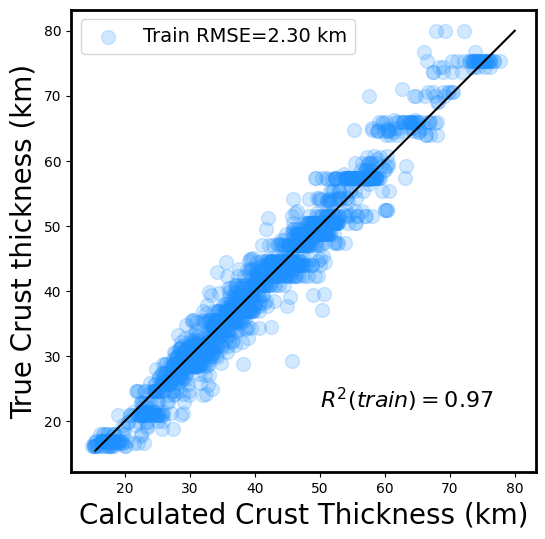

In [25]:
plt.figure(figsize = (6,6))
p1 = max(max(y_xgb), max(y_test))
p2 = min(min(y_xgb), min(y_test))
plt.plot([p1, p2], [p1, p2], 'black')
# plt.yscale([0,80])
# plt.xscale([0,80])
plt.ylabel('True Crust thickness (km)', fontsize=20)
plt.xlabel('Calculated Crust Thickness (km)', fontsize=20)
text_position=[50, 20]
# plt.scatter( y_xgb, y_test,s = 100, marker="o", c = 'orangered' ,
#             label="Test RMSE={:.2f} km".format(RMSE),alpha = 0.2)
plt.scatter( y_xgb_train,y_train,s = 100,  marker="o", c = 'dodgerblue',
             label="Train RMSE={:.2f} km".format(RMSE2),alpha = 0.2)

plt.legend(loc="upper left", fontsize=14)
# plt.text(text_position[0], text_position[1]-2,
#          r'$R^2(test)=${:.2f} '.format(R2_xg),
#          fontdict={'size': 16, 'color': '#000000'})
plt.text(text_position[0], text_position[1]+2,
         r'$R^2(train)=${:.2f} '.format(R2_xg2),
         fontdict={'size': 16, 'color': '#000000'})
#plt.title('Xgboost model with Gangdese this study', fontsize=20)
# 添加边框并设置线宽
ax = plt.gca()  # 获取当前的坐标轴
for _, spine in ax.spines.items():
    spine.set_linewidth(2)
# plt.xticks((10,80,10))
# plt.yticks((10,80,10))
#plt.tick_params(axis='both', which='both', direction='out', length=6, width=1)
y_test1 = y_test.values
plt.grid(False)
#plt.savefig('Train.eps' ,format = 'eps')
percentage = error_less_than_five(y_xgb, y_test,RMSE)
print(f"Percentage of data points with an error strictly less than RMSE: {percentage:.2f}%")


<Figure size 600x600 with 0 Axes>

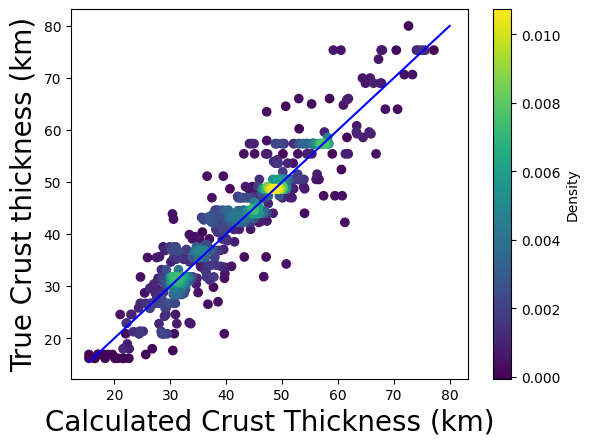

In [26]:
plt.figure(figsize = (6,6))
density_scatter( y_xgb, y_test1, bins = [30,30] )
plt.plot([p1, p2], [p1, p2], 'blue')
plt.ylabel('True Crust thickness (km)', fontsize=20)
plt.xlabel('Calculated Crust Thickness (km)', fontsize=20)
plt.grid(False)
#plt.savefig('Dencity.eps' ,format = 'eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


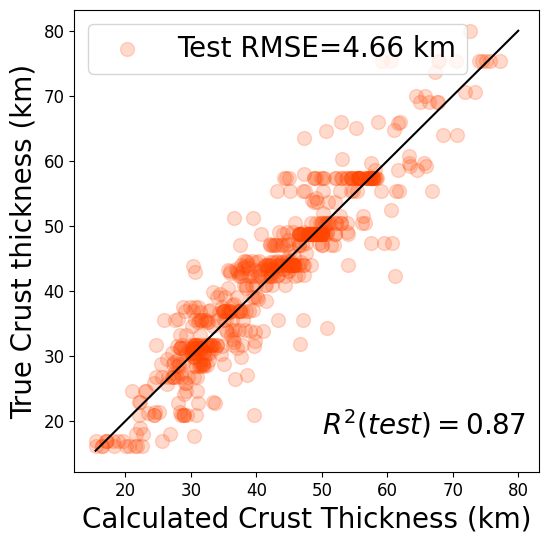

In [27]:
plt.figure(figsize = (6,6))

p1 = max(max(y_xgb), max(y_test))
p2 = min(min(y_xgb), min(y_test))
plt.plot([p1, p2], [p1, p2], 'black')
plt.ylabel('True Crust thickness (km)', fontsize=20)
plt.xlabel('Calculated Crust Thickness (km)', fontsize=20)
text_position=[50, 20]
plt.scatter( y_xgb, y_test,s = 100, marker="o", c = 'orangered' ,
             label="Test RMSE={:.2f} km".format(RMSE),alpha = 0.2)
plt.legend(loc="upper left", fontsize=20)
plt.text(text_position[0], text_position[1]-2,
         r'$R^2(test)=${:.2f} '.format(R2_xg),
         fontdict={'size': 20, 'color': '#000000'})

#plt.title('Xgboost model with Gangdese this study', fontsize=20)
plt.tick_params(labelsize=12)
y_test1 = y_test.values
plt.grid(False)
#plt.savefig(' test.eps' ,format = 'eps')
plt.show()

## calculations of training and test error and calculations of statistics

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


50% Confidence Interval: [-2.57176315  1.8225824 ]
90% Confidence Interval: [-7.62812366  7.5122435 ]
95% Confidence Interval: [-10.44181099  10.03396205]
98% Confidence Interval: [-13.35587914  12.47523835]


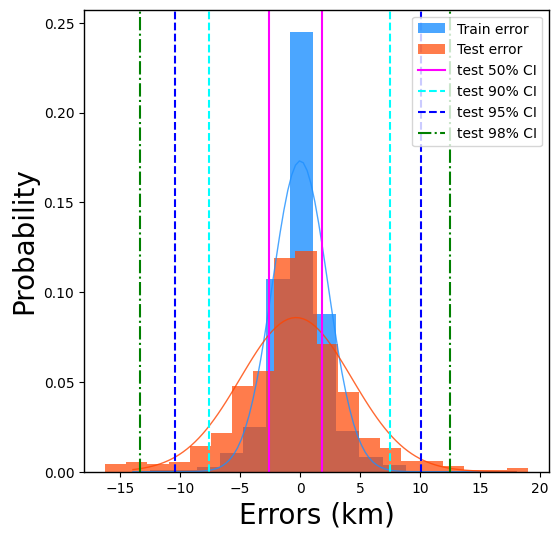

In [29]:
y_train_error = y_xgb_train - y_train
y_test_error = y_xgb - y_test
mean_train = np.mean(y_train_error)
std_dev_train = np.std(y_train_error)

mean_test = np.mean(y_test_error)
std_dev_test = np.std(y_test_error)

plt.figure(figsize = (6,6))
plt.hist(y_train_error, bins = 15, density=True,color = 'dodgerblue', alpha=.8  , label = 'Train error')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = stats.norm.pdf(x, mean_train, std_dev_train)
plt.plot(x, p1, 'k', linewidth=1,c = 'dodgerblue',alpha=.8 )

plt.hist(y_test_error, bins = 20, density=True,color ='orangered' , alpha=.7 , label = 'Test error')

# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
p2 = stats.norm.pdf(x, mean_test, std_dev_test)
plt.plot(x, p2, 'k', linewidth=1,c = 'orangered',alpha=.8 )

data = y_test_error

# Confidence intervals using the percentile method
ci_95 = np.percentile(data, [2.5, 97.5])
ci_98 = np.percentile(data, [1, 99])
ci_90 = np.percentile(data, [5, 95])
ci_50 = np.percentile(data, [25, 75])

# Print the confidence intervals
print("50% Confidence Interval:", ci_50)
print("90% Confidence Interval:", ci_90)
print("95% Confidence Interval:", ci_95)
print("98% Confidence Interval:", ci_98)


# Add vertical lines for the confidence intervals
#plt.axvline(mean, color='red', linestyle='-', label='Mean')
plt.axvline(ci_50[0], color='magenta', linestyle='-', label='test 50% CI')
plt.axvline(ci_50[1], color='magenta', linestyle='-')
plt.axvline(ci_90[0], color='cyan', linestyle='--', label='test 90% CI')
plt.axvline(ci_90[1], color='cyan', linestyle='--')
plt.axvline(ci_95[0], color='blue', linestyle='--', label='test 95% CI')
plt.axvline(ci_95[1], color='blue', linestyle='--')
plt.axvline(ci_98[0], color='green', linestyle='-.', label='test 98% CI')
plt.axvline(ci_98[1], color='green', linestyle='-.')


plt.legend(loc='upper right')

ax = plt.gca()

for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)

ax.xaxis.set_ticks_position('bottom')  # 显示x轴刻度
ax.yaxis.set_ticks_position('left')    # 显示y轴刻度
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Errors (km)', fontsize=20)
plt.grid(False)
#plt.savefig('error.eps' ,format = 'eps')
plt.show()

### test error

50% Confidence Interval: [-2.57176315  1.8225824 ]
90% Confidence Interval: [-7.62812366  7.5122435 ]
95% Confidence Interval: [-10.44181099  10.03396205]
98% Confidence Interval: [-13.35587914  12.47523835]


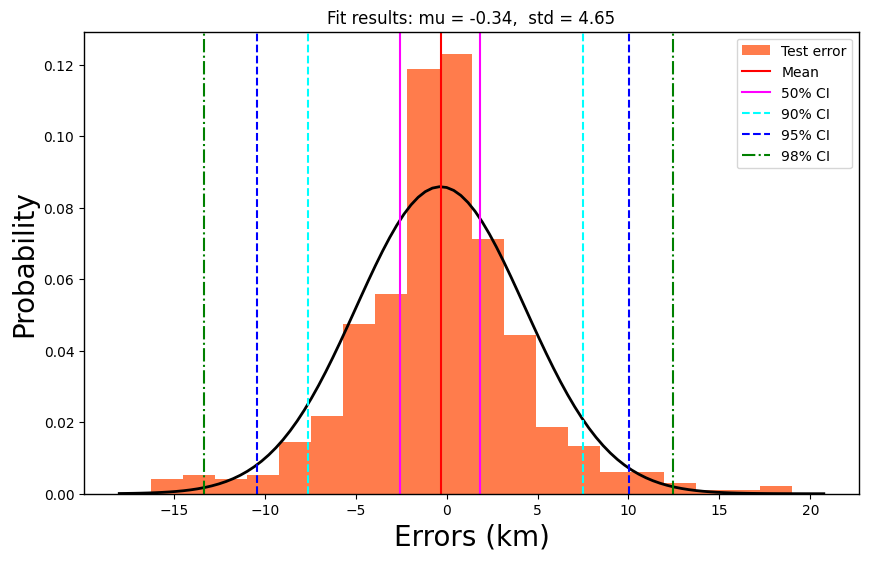

In [32]:
data = y_test_error
# Calculate statistics
mean = np.mean(data)
std_dev = np.std(data)

# Confidence intervals using the percentile method
ci_95 = np.percentile(data, [2.5, 97.5])
ci_98 = np.percentile(data, [1, 99])
ci_90 = np.percentile(data, [5, 95])
ci_50 = np.percentile(data, [25, 75])

# Print the confidence intervals
print("50% Confidence Interval:", ci_50)
print("90% Confidence Interval:", ci_90)
print("95% Confidence Interval:", ci_95)
print("98% Confidence Interval:", ci_98)

# Plotting
plt.figure(figsize=(10, 6))

# Histogram of the data
plt.hist(data,  bins = 20, density=True,color ='orangered' , alpha=.7 , label = 'Test error')

# Overlay the PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std_dev)
plt.plot(x, p, 'k', linewidth=2)

# Add vertical lines for the confidence intervals
plt.axvline(mean, color='red', linestyle='-', label='Mean')
plt.axvline(ci_50[0], color='magenta', linestyle='-', label='50% CI')
plt.axvline(ci_50[1], color='magenta', linestyle='-')
plt.axvline(ci_90[0], color='cyan', linestyle='--', label='90% CI')
plt.axvline(ci_90[1], color='cyan', linestyle='--')
plt.axvline(ci_95[0], color='blue', linestyle='--', label='95% CI')
plt.axvline(ci_95[1], color='blue', linestyle='--')
plt.axvline(ci_98[0], color='green', linestyle='-.', label='98% CI')
plt.axvline(ci_98[1], color='green', linestyle='-.')

tit = "Fit results: mu = %.2f,  std = %.2f" % (mean, std_dev)
plt.title(tit)
plt.legend()


ax = plt.gca()

for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)

ax.xaxis.set_ticks_position('bottom')  # 显示x轴刻度
ax.yaxis.set_ticks_position('left')    # 显示y轴刻度
plt.ylabel('Probability', fontsize=20)
plt.xlabel('Errors (km)', fontsize=20)
plt.grid(False)
plt.show()

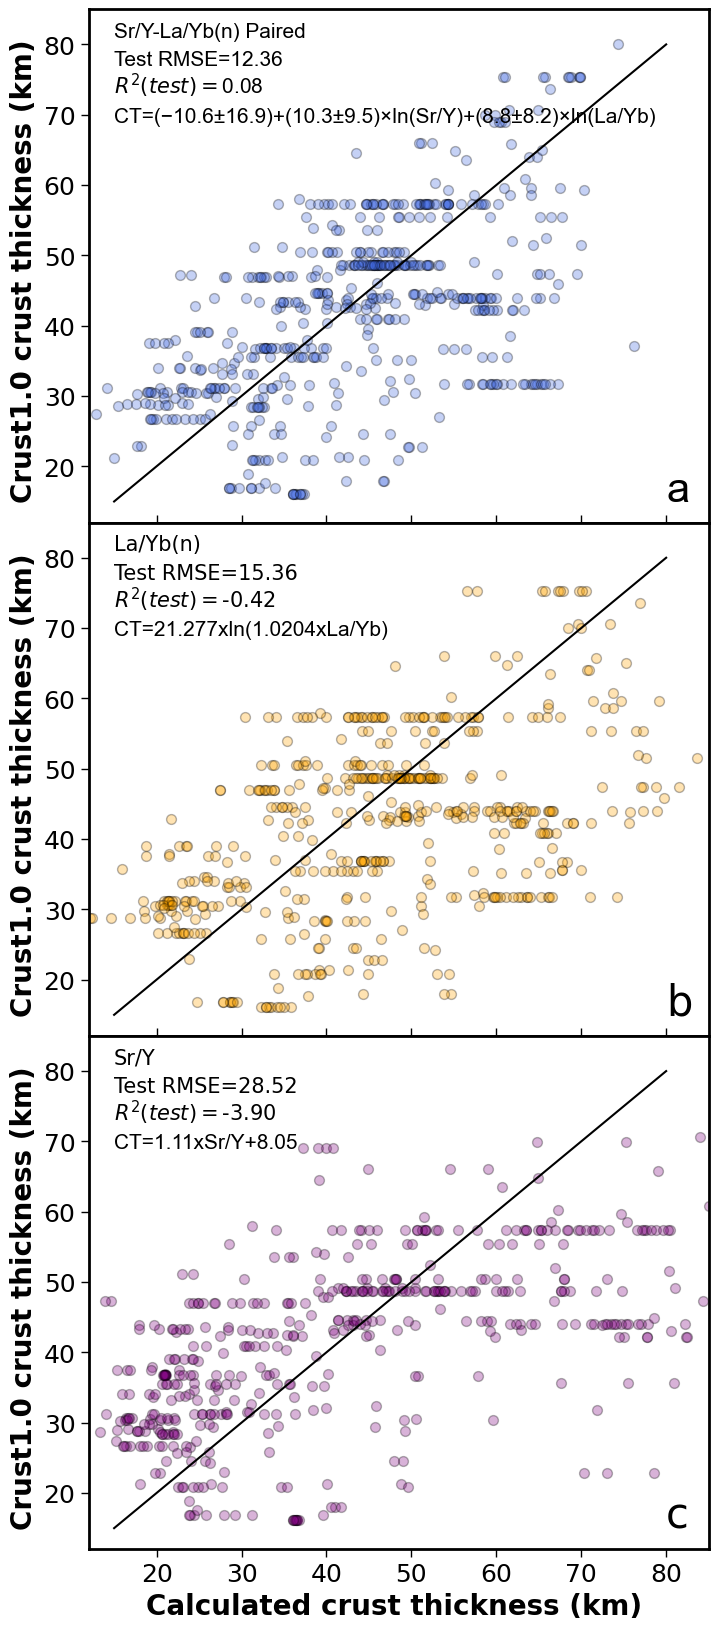

In [33]:
# Create a figure and a 3x1 grid of subplots
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 20), gridspec_kw={'hspace': 0})
text_position=[15, 75]
text_position2=[80, 15]
p1 = max(80,80)
p2 = min(15, 15)
SrY=title['Sr/Y']
layb=title['Ln((La/Yb)n)']
y_srylayb = 8.8*(layb)+10.3*np.log(SrY)-10.6
MAE = mean_absolute_error(y_test, y_srylayb)
MSE = mean_squared_error(y_test,y_srylayb)
R2_xg = r2_score(y_test, y_srylayb)
RMSE = np.sqrt(MSE)
#plt.scatter(y_test, y_xgb, color = 'brown')
#plt.scatter(y_train, y_xgb_train, color = 'lightyellow')
#plt.xlabel('True Test Values')
#plt.ylabel('Predictions from Model')
axs[0].set_xlim((12, 85))
axs[0].set_ylim((12, 85))
axs[0].plot([p1, p2], [p1, p2], 'black')
axs[0].set_ylabel('Crust1.0 crust thickness (km) ', fontsize=20,fontweight='bold')
#axs[0].set_xlabel('Calculated crust thickness (km) ', fontsize=20,fontweight='bold')

axs[0].scatter(y_srylayb, y_test,s = 50, marker="o", c = 'royalblue', edgecolors='black',
                  label="Test RMSE={:.2f}".format(RMSE),alpha= 0.3)
#plt.legend(loc="upper left", fontsize=20)
axs[0].text(text_position[0], text_position[1]+2,
               r'Test RMSE={:.2f}'.format(RMSE),
               fontdict={'size': 15,'family': 'Arial', 'color': '#000000'})
axs[0].text(text_position[0], text_position[1]-2,
               r'$R^2(test)=${:.2f}'.format(R2_xg),
               fontdict={'size': 15,'family': 'Arial', 'color': '#000000'})
axs[0].text(text_position2[0], text_position2[1],
               r'a',fontdict={'size': 30,'family': 'Arial', 'color': '#000000'})
axs[0].text(text_position[0], text_position[1]+6,
            r'Sr/Y-La/Yb(n) Paired',fontdict={'size': 15, 'family': 'Arial','color': '#000000'})
axs[0].text(text_position[0], text_position[1]-6,
            r'CT=(−10.6±16.9)+(10.3±9.5)×ln(Sr/Y)+(8.8±8.2)×ln(La/Yb)',fontdict={'size': 15, 'family': 'Arial','color': '#000000'})
#axs[0].tick_params(labelsize=20)
axs[0].set_yticks(np.arange(20, 89, step=10))
axs[0].set_xticks(np.arange(20,89,step=10))
#axs[0].tick_params(width=2, length=10)  
for _, spine in axs[0].spines.items():
    spine.set_linewidth(2)  
    spine.set_color('black')
axs[0].tick_params(axis='both', which='both',  bottom=True, top=False, left=True, right=False,labelbottom=False, labelleft=True,direction='out', length=6, width=1,labelsize=18)
#axs[0].set_title('La/Yb(n) Sr/Y Paired', fontsize=20)
axs[0].grid(False)

layb=title['Ln((La/Yb)n)']
y_layb = 21.277* (layb+np.log(1.0204))#(np.log(1.0204layb))
MAE = mean_absolute_error(y_test, y_layb)
MSE = mean_squared_error(y_test,y_layb)
R2_xg = r2_score(y_test, y_layb)
RMSE = np.sqrt(MSE)
#plt.scatter(y_test, y_xgb, color = 'brown')
#plt.scatter(y_train, y_xgb_train, color = 'lightyellow')
#plt.xlabel('True Test Values')
#plt.ylabel('Predictions from Model')
# plt.xlim((12, 85))
# plt.ylim((12, 85))
axs[1].set_xlim((12, 85))
axs[1].set_ylim((12, 85))
axs[1].plot([p1, p2], [p1, p2], 'black')
axs[1].set_ylabel('Crust1.0 crust thickness (km) ', fontsize=20,fontweight='bold')
#axs[1].set_xlabel('Calculated crust thickness (km) ', fontsize=20,fontweight='bold')
axs[1].scatter(y_layb, y_test,s = 50, marker="o", c = 'orange', edgecolors='black',
                  label="Test RMSE={:.2f}".format(RMSE),alpha= 0.3)
#density_scatter(y_layb, y_test, bins = [30,30] )
#plt.legend(loc="upper left", fontsize=15)
axs[1].text(text_position[0], text_position[1]+2,
               r'Test RMSE={:.2f}'.format(RMSE),
               fontdict={'size': 15, 'color': '#000000'})
axs[1].text(text_position[0], text_position[1]-2,
               r'$R^2(test)=${:.2f}'.format(R2_xg),
               fontdict={'size': 15, 'color': '#000000'})
axs[1].text(text_position2[0], text_position2[1],
               r'b',fontdict={'size': 30, 'color': '#000000'})
axs[1].text(text_position[0], text_position[1]+6,
            r'La/Yb(n)',fontdict={'size': 15, 'color': '#000000'})
axs[1].text(text_position[0], text_position[1]-6,
            r'CT=21.277xln(1.0204xLa/Yb)',fontdict={'size': 15, 'family': 'Arial','color': '#000000'})

#axs[1].set_title('La/Yb(n)', fontsize=20)
#axs[1].tick_params(labelsize=20)
for _, spine in axs[1].spines.items():
    spine.set_linewidth(2)
    spine.set_color('black')
axs[1].tick_params(axis='both', which='both',  bottom=True, top=True, left=True, right=False,labelbottom=False, labelleft=True,direction='out', length=6, width=1,labelsize=18)
axs[1].set_yticks(np.arange(20, 89, step=10))
axs[1].set_xticks(np.arange(20,89,step=10))
axs[1].grid(False)

SrY=title['Sr/Y']
y_sry = 1.11*SrY+8.05
MAE = mean_absolute_error(y_test, y_sry)
MSE = mean_squared_error(y_test,y_sry)
R2_xg = r2_score(y_test, y_sry)
RMSE = np.sqrt(MSE)
#fig=plt.figure(figsize = (6,6))
#plt.scatter(y_test, y_xgb, color = 'brown')
#plt.scatter(y_train, y_xgb_train, color = 'lightyellow')
#plt.xlabel('True Test Values')
#plt.ylabel('Predictions from Model')
# plt.xlim((0, 100))
# plt.ylim((5, 100))
axs[2].set_xlim((12, 85))
axs[2].set_ylim((12, 85))
axs[2].plot([p1, p2], [p1, p2], 'black')
axs[2].set_ylabel('Crust1.0 crust thickness (km) ', fontsize=20,fontweight='bold')
axs[2].set_xlabel('Calculated crust thickness (km) ', fontsize=20,fontweight='bold')
axs[2].scatter(y_sry, y_test,s = 50, marker="o", c = 'purple', edgecolors='black',
                  label="Test RMSE={:.2f}".format(RMSE),alpha= 0.3)
#plt.legend(loc="upper left", fontsize=15)
axs[2].text(text_position[0], text_position[1]+2,
               r'Test RMSE={:.2f}'.format(RMSE),
               fontdict={'size': 15, 'color': '#000000'})
axs[2].text(text_position[0], text_position[1]-2,
               r'$R^2(test)=${:.2f}'.format(R2_xg),
               fontdict={'size': 15, 'color': '#000000'})
axs[2].text(text_position2[0], text_position2[1],
               r'c',fontdict={'size': 30, 'color': '#000000'})
axs[2].text(text_position[0], text_position[1]+6,
            r'Sr/Y',fontdict={'size': 15, 'color': '#000000'})
axs[2].text(text_position[0], text_position[1]-6,
            r'CT=1.11xSr/Y+8.05',fontdict={'size': 15, 'family': 'Arial','color': '#000000'})

for _, spine in axs[2].spines.items():
    spine.set_linewidth(2)
    spine.set_color('black')
axs[2].tick_params(axis='both', which='both',  bottom=True, top=True, left=True, right=False,labelbottom=True, labelleft=True,direction='out', length=6, width=1,labelsize=18)
axs[2].set_yticks(np.arange(20, 89, step=10))
axs[2].set_xticks(np.arange(20,89,step=10))
axs[2].grid(False)

#plt.savefig('images/Fig2.jpg' ,format = 'jpg', dpi = 600)
#plt.tight_layout()


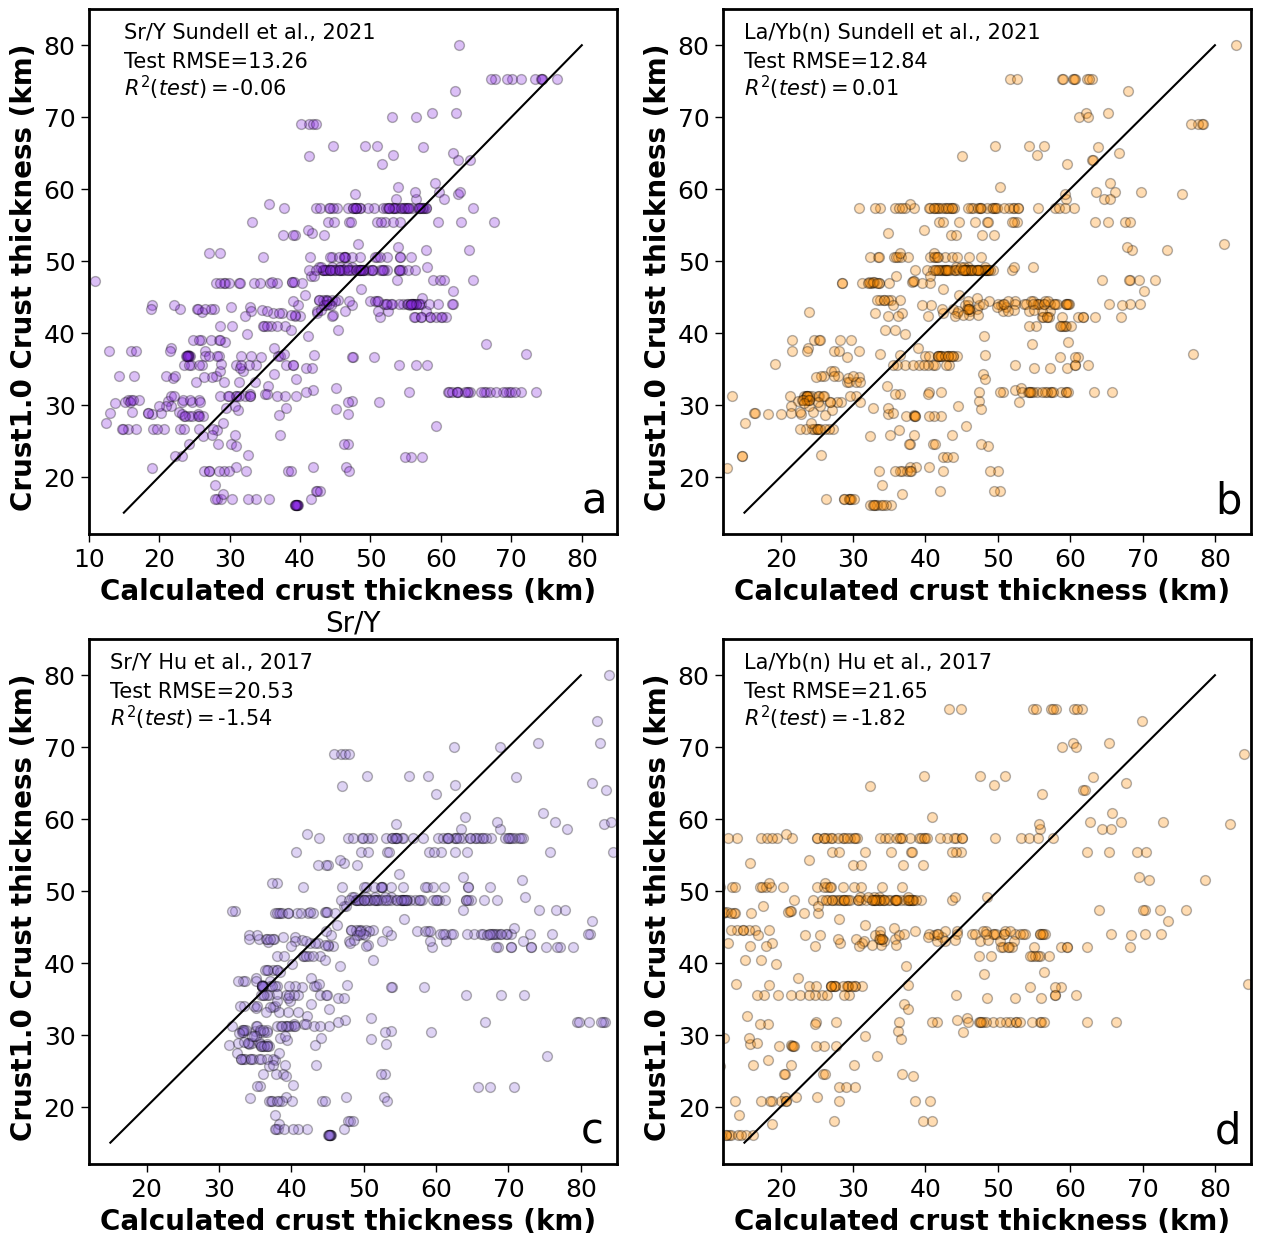

In [34]:
# Create a figure and a 2x3 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
text_position=[15, 75]
text_position2=[80, 15]
p1 = max(80,80)
p2 = min(15, 15)

SrY=title['Sr/Y']
layb=title['Ln((La/Yb)n)']
y_sry_sundell = 19.6*np.log(SrY)-24.0
MAE = mean_absolute_error(y_test,y_sry_sundell)
MSE = mean_squared_error(y_test,y_sry_sundell)
R2_xg = r2_score(y_test, y_sry_sundell)
RMSE = np.sqrt(MSE)
#plt.scatter(y_test, y_xgb, color = 'brown')
#plt.scatter(y_train, y_xgb_train, color = 'lightyellow')
#plt.xlabel('True Test Values')
#plt.ylabel('Predictions from Model')
#plt.xlim((3, 120))
# plt.ylim((60, 80))
axs[0, 0].set_xlim((12, 85))
axs[0, 0].set_ylim((12, 85))
axs[0, 0].plot([p1, p2], [p1, p2], 'black')
axs[0, 0].set_ylabel('Crust1.0 Crust thickness (km) ', fontsize=20,fontweight='bold')
axs[0, 0].set_xlabel('Calculated crust thickness (km) ', fontsize=20,fontweight='bold')
axs[0, 0].scatter(y_sry_sundell, y_test,s = 50, marker="o", c = 'blueviolet',edgecolors='black',
                  label="Test RMSE={:.2f}".format(RMSE),alpha= 0.3)
#plt.legend(loc="upper left", fontsize=20)
axs[0, 0].text(text_position[0], text_position[1]+2,
               r'Test RMSE={:.2f}'.format(RMSE),
               fontdict={'size': 15, 'color': '#000000'})
axs[0, 0].text(text_position[0], text_position[1]-2,
               r'$R^2(test)=${:.2f}'.format(R2_xg),
               fontdict={'size': 15, 'color': '#000000'})
axs[0, 0].text(text_position[0], text_position[1]+6,
               r'Sr/Y Sundell et al., 2021',
               fontdict={'size': 15, 'color': '#000000'})
axs[0, 0].text(text_position2[0], text_position2[1],
               r'a',fontdict={'size': 30, 'color': '#000000'})
axs[0, 0].tick_params(labelsize=20)
axs[0, 0].set_yticks(np.arange(20, 89, step=10))
axs[0, 0].set_xticks(np.arange(10,89,step=10))
for _, spine in axs[0,0].spines.items():
    spine.set_linewidth(2)
    spine.set_color('black')
axs[0,0].tick_params(axis='both', which='both',  bottom=True, top=False, left=True, right=False,labelbottom=True, labelleft=True,direction='out', length=6, width=1,labelsize=18)
#axs[0, 0].set_title('Sr/Y', fontsize=20)
axs[0, 0].grid(False)

SrY=title['Sr/Y']
laybn=title['Ln((La/Yb)n)']
y_laybsundell = 17.0*(laybn)+6.9
MAE = mean_absolute_error(y_test, y_laybsundell)
MSE = mean_squared_error(y_test,y_laybsundell)
R2_xg = r2_score(y_test, y_laybsundell)
RMSE = np.sqrt(MSE)
#plt.scatter(y_test, y_xgb, color = 'brown')
#plt.scatter(y_train, y_xgb_train, color = 'lightyellow')
#plt.xlabel('True Test Values')
#plt.ylabel('Predictions from Model')
# plt.xlim((40, 80))
# plt.ylim((60, 80))
axs[0, 1].set_xlim((12, 85))
axs[0, 1].set_ylim((12, 85))
axs[0, 1].plot([p1, p2], [p1, p2], 'black')
axs[0, 1].set_ylabel('Crust1.0 Crust thickness (km) ', fontsize=20,fontweight='bold')
axs[0, 1].set_xlabel('Calculated crust thickness (km) ', fontsize=20,fontweight='bold')
axs[0, 1].scatter(y_laybsundell, y_test,s = 50, marker="o", c = 'darkorange',edgecolors='black',
                  label="Test RMSE={:.2f}".format(RMSE),alpha= 0.3)
#plt.legend(loc="upper left", fontsize=20)
axs[0, 1].text(text_position[0], text_position[1]+2,
               r'Test RMSE={:.2f}'.format(RMSE),
               fontdict={'size': 15, 'color': '#000000'})
axs[0, 1].text(text_position[0], text_position[1]-2,
               r'$R^2(test)=${:.2f}'.format(R2_xg),
               fontdict={'size': 15, 'color': '#000000'})
axs[0, 1].text(text_position[0], text_position[1]+6,
               r'La/Yb(n) Sundell et al., 2021',
               fontdict={'size': 15, 'color': '#000000'})
axs[0, 1].text(text_position2[0], text_position2[1],
               r'b',fontdict={'size': 30, 'color': '#000000'})
axs[0, 1].tick_params(labelsize=20)
axs[0, 1].set_yticks(np.arange(20, 89, step=10))
axs[0, 1].set_xticks(np.arange(20,89,step=10))
for _, spine in axs[0,1].spines.items():
    spine.set_linewidth(2)
    spine.set_color('black')
axs[0,1].tick_params(axis='both', which='both',  bottom=True, top=False, left=True, right=False,labelbottom=True, labelleft=True,direction='out', length=6, width=1,labelsize=18)
#axs[0, 1].set_title('La/Yb(n)', fontsize=20)
axs[0, 1].grid(False)

SrY=title['Sr/Y']
y_sryHU =0.67*SrY+28.21
MAE = mean_absolute_error(y_test, y_sryHU)
MSE = mean_squared_error(y_test,y_sryHU)
R2_xg = r2_score(y_test, y_sryHU)
RMSE = np.sqrt(MSE)
#plt.scatter(y_test, y_xgb, color = 'brown')
#plt.scatter(y_train, y_xgb_train, color = 'lightyellow')
#plt.xlabel('True Test Values')
#plt.ylabel('Predictions from Model')
# plt.xlim((40, 80))
# plt.ylim((60, 80))
axs[1, 0].set_xlim((12, 85))
axs[1, 0].set_ylim((12, 85))
axs[1, 0].plot([p1, p2], [p1, p2], 'black')
axs[1, 0].set_ylabel('Crust1.0 Crust thickness (km) ', fontsize=20,fontweight='bold')
axs[1, 0].set_xlabel('Calculated crust thickness (km) ', fontsize=20,fontweight='bold')
axs[1, 0].scatter(y_sryHU, y_test,s = 50, marker="o", c = 'mediumpurple',edgecolors='black',
                  label="Test RMSE={:.2f}".format(RMSE),alpha= 0.3)
axs[1, 0].text(text_position[0], text_position[1]+2,
               r'Test RMSE={:.2f}'.format(RMSE),
               fontdict={'size': 15, 'color': '#000000'})
axs[1, 0].text(text_position[0], text_position[1]-2,
               r'$R^2(test)=${:.2f}'.format(R2_xg),
               fontdict={'size': 15, 'color': '#000000'})
axs[1, 0].text(text_position[0], text_position[1]+6,
               r'Sr/Y Hu et al., 2017',
               fontdict={'size': 15, 'color': '#000000'})
axs[1, 0].text(text_position2[0], text_position2[1],
               r'c',fontdict={'size': 30, 'color': '#000000'})
axs[1, 0].tick_params(labelsize=20)
axs[1, 0].set_yticks(np.arange(20, 89, step=10))
axs[1, 0].set_xticks(np.arange(20,89,step=10))
axs[1, 0].set_title('Sr/Y', fontsize=20)
for _, spine in axs[1,0].spines.items():
    spine.set_linewidth(2)
    spine.set_color('black')
axs[1,0].tick_params(axis='both', which='both',  bottom=True, top=False, left=True, right=False,labelbottom=True, labelleft=True,direction='out', length=6, width=1,labelsize=18)
#axs[0, 1].set_title('La/Yb(n)', fontsize=20)
axs[1, 0].grid(False)


SrY=title['Sr/Y']
laybn=title['Ln((La/Yb)n)']
y_laybHU = 27.78*(laybn+np.log((0.34)))
MAE = mean_absolute_error(y_test, y_laybHU)
MSE = mean_squared_error(y_test,y_laybHU)
R2_xg = r2_score(y_test, y_laybHU)
RMSE = np.sqrt(MSE)
#plt.scatter(y_test, y_xgb, color = 'brown')
#plt.scatter(y_train, y_xgb_train, color = 'lightyellow')
#plt.xlabel('True Test Values')
#plt.ylabel('Predictions from Model')
# plt.xlim((40, 80))
# plt.ylim((60, 80))
axs[1, 1].set_xlim((12, 85))
axs[1, 1].set_ylim((12, 85))
axs[1, 1].plot([p1, p2], [p1, p2], 'black')
axs[1, 1].set_ylabel('Crust1.0 Crust thickness (km) ', fontsize=20,fontweight='bold')
axs[1, 1].set_xlabel('Calculated crust thickness (km) ', fontsize=20,fontweight='bold')
axs[1, 1].scatter(y_laybHU, y_test,s = 50, marker="o", c = 'darkorange',edgecolors='black',
                  label="Test RMSE={:.2f}".format(RMSE),alpha= 0.3)
#plt.legend(loc="upper left", fontsize=20)
axs[1, 1].text(text_position[0], text_position[1]+2,
               r'Test RMSE={:.2f}'.format(RMSE),
               fontdict={'size': 15, 'color': '#000000'})
axs[1, 1].text(text_position[0], text_position[1]-2,
               r'$R^2(test)=${:.2f}'.format(R2_xg),
               fontdict={'size': 15, 'color': '#000000'})
axs[1, 1].text(text_position[0], text_position[1]+6,
               r'La/Yb(n) Hu et al., 2017',
               fontdict={'size': 15, 'color': '#000000'})
axs[1, 1].text(text_position2[0], text_position2[1],
               r'd',fontdict={'size': 30, 'color': '#000000'})
axs[1, 1].tick_params(labelsize=20)
axs[1, 1].set_yticks(np.arange(20, 89, step=10))
axs[1, 1].set_xticks(np.arange(20,89,step=10))
#axs[1, 1].set_title('La/Yb(n)', fontsize=20)
for _, spine in axs[1,1].spines.items():
    spine.set_linewidth(2)
    spine.set_color('black')
axs[1,1].tick_params(axis='both', which='both',  bottom=True, top=False, left=True, right=False,labelbottom=True, labelleft=True,direction='out', length=6, width=1,labelsize=18)
#axs[0, 1].set_title('La/Yb(n)', fontsize=20)
axs[1, 1].grid(False)



50% Confidence Interval: [-6.98261495  9.33072869]
90% Confidence Interval: [-15.07902569  26.00558953]
95% Confidence Interval: [-17.6522033   28.89136509]
98% Confidence Interval: [-19.43251222  33.28595084]
50% Confidence Interval: [-6.96493739 16.40522716]
90% Confidence Interval: [-16.27306586  31.14460402]
95% Confidence Interval: [-18.78586874  33.57370123]
98% Confidence Interval: [-20.583657    35.40634051]
50% Confidence Interval: [-9.81401687 18.88636364]
90% Confidence Interval: [-20.58575623  67.00812056]
95% Confidence Interval: [-23.58694286  91.42645763]
98% Confidence Interval: [-28.15466909 109.78248276]
50% Confidence Interval: [-8.48082204  6.46419796]
90% Confidence Interval: [-17.69147323  27.15699161]
95% Confidence Interval: [-22.25571215  33.25545039]
98% Confidence Interval: [-25.84219371  37.3233141 ]
50% Confidence Interval: [-26.37655111   0.70982607]
90% Confidence Interval: [-37.82304028  21.06592637]
95% Confidence Interval: [-40.74746526  24.29264949]
9

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


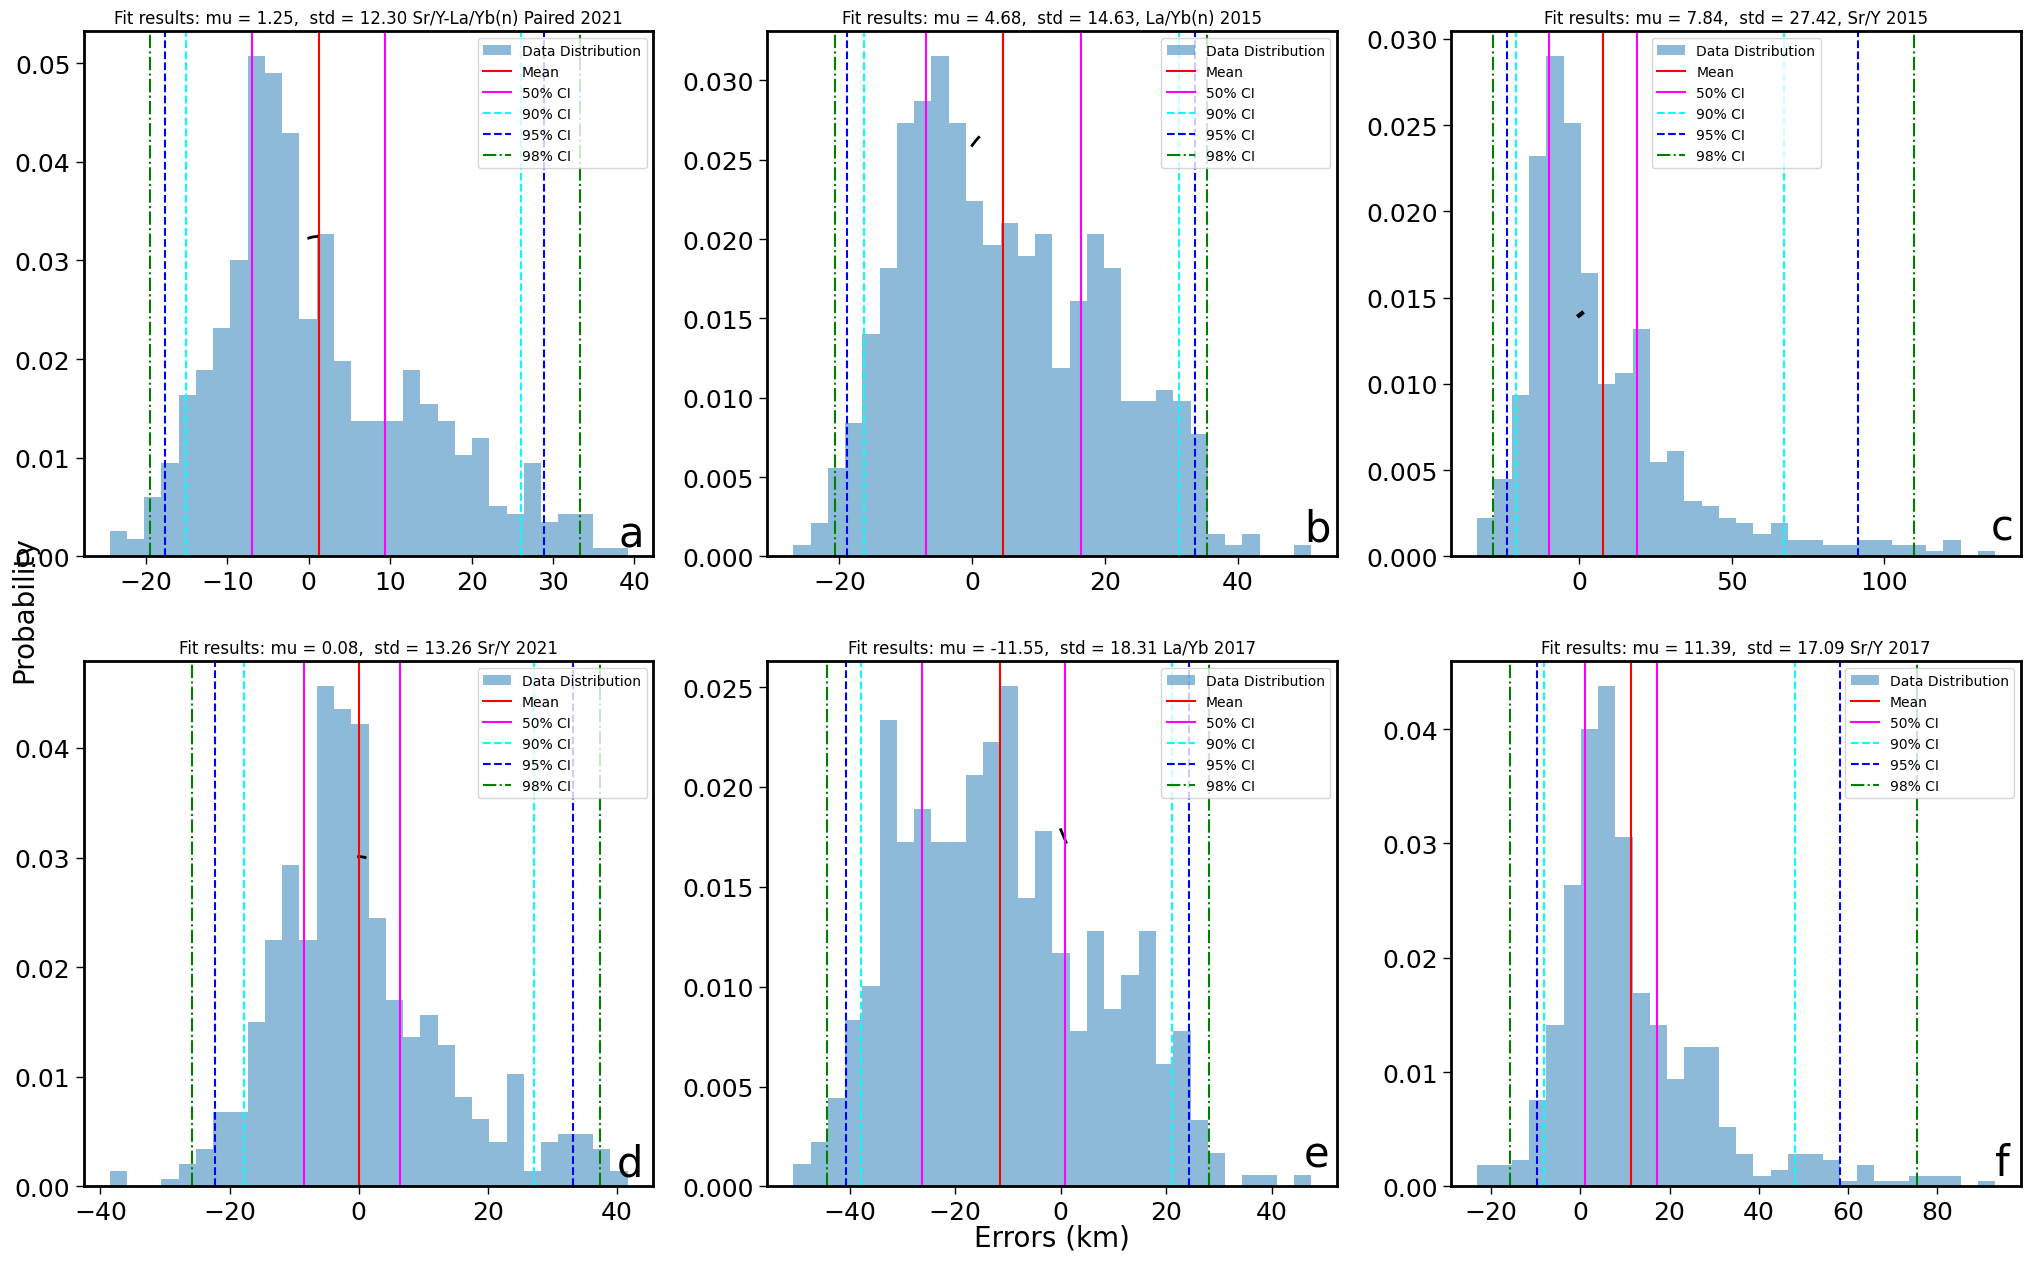

In [51]:
# Create a figure and a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(25, 15))
text_position2=[40, 0.001]

# Plot data on each subplot
SrY=title['Sr/Y']
layb=title['Ln((La/Yb)n)']
y_srylayb = 8.8*(layb)+10.3*np.log(SrY)-10.6
data = y_srylayb - y_test
# Calculate statistics
mean = np.mean(data)
std_dev = np.std(data)

# Confidence intervals using the percentile method
ci_95 = np.percentile(data, [2.5, 97.5])
ci_98 = np.percentile(data, [1, 99])
ci_90 = np.percentile(data, [5, 95])
ci_50 = np.percentile(data, [25, 75])

# Print the confidence intervals
print("50% Confidence Interval:", ci_50)
print("90% Confidence Interval:", ci_90)
print("95% Confidence Interval:", ci_95)
print("98% Confidence Interval:", ci_98)

# Plotting
#plt.figure(figsize=(10, 6))

# Histogram of the data
axs[0, 0].hist(data, bins=30, density=True, alpha=0.5, label='Data Distribution')

# Overlay the PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std_dev)
axs[0, 0].plot(x, p, 'k', linewidth=2)

# Add vertical lines for the confidence intervals
axs[0, 0].axvline(mean, color='red', linestyle='-', label='Mean')
axs[0, 0].axvline(ci_50[0], color='magenta', linestyle='-', label='50% CI')
axs[0, 0].axvline(ci_50[1], color='magenta', linestyle='-')
axs[0, 0].axvline(ci_90[0], color='cyan', linestyle='--', label='90% CI')
axs[0, 0].axvline(ci_90[1], color='cyan', linestyle='--')
axs[0, 0].axvline(ci_95[0], color='blue', linestyle='--', label='95% CI')
axs[0, 0].axvline(ci_95[1], color='blue', linestyle='--')
axs[0, 0].axvline(ci_98[0], color='green', linestyle='-.', label='98% CI')
axs[0, 0].axvline(ci_98[1], color='green', linestyle='-.')
axs[0, 0].text(38, text_position2[1],
               r'a',fontdict={'size': 30, 'color': '#000000'})

tit = "Fit results: mu = %.2f,  std = %.2f Sr/Y-La/Yb(n) Paired 2021" % (mean, std_dev)
axs[0, 0].set_title(tit)
axs[0, 0].legend()
axs[0, 0].grid(False)
#plt.savefig('LaybnSRY.eps', format='eps')


# axs[0, 1].scatter(x, y, s=area, c=colors, alpha=0.5)
# axs[0, 1].set_title('Axis [0, 1]')
layb=title['Ln((La/Yb)n)']
y_layb = 21.277* (layb+np.log(1.0204))#(np.log(1.0204layb))
data = y_layb - y_test
# Calculate statistics
mean = np.mean(data)
std_dev = np.std(data)

# Confidence intervals using the percentile method
ci_95 = np.percentile(data, [2.5, 97.5])
ci_98 = np.percentile(data, [1, 99])
ci_90 = np.percentile(data, [5, 95])
ci_50 = np.percentile(data, [25, 75])

# Print the confidence intervals
print("50% Confidence Interval:", ci_50)
print("90% Confidence Interval:", ci_90)
print("95% Confidence Interval:", ci_95)
print("98% Confidence Interval:", ci_98)

# Plotting
#plt.figure(figsize=(10, 6))

# Histogram of the data
axs[0, 1].hist(data, bins=30, density=True, alpha=0.5, label='Data Distribution')

# Overlay the PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std_dev)
axs[0, 1].plot(x, p, 'k', linewidth=2)

# Add vertical lines for the confidence intervals
axs[0, 1].axvline(mean, color='red', linestyle='-', label='Mean')
axs[0, 1].axvline(ci_50[0], color='magenta', linestyle='-', label='50% CI')
axs[0, 1].axvline(ci_50[1], color='magenta', linestyle='-')
axs[0, 1].axvline(ci_90[0], color='cyan', linestyle='--', label='90% CI')
axs[0, 1].axvline(ci_90[1], color='cyan', linestyle='--')
axs[0, 1].axvline(ci_95[0], color='blue', linestyle='--', label='95% CI')
axs[0, 1].axvline(ci_95[1], color='blue', linestyle='--')
axs[0, 1].axvline(ci_98[0], color='green', linestyle='-.', label='98% CI')
axs[0, 1].axvline(ci_98[1], color='green', linestyle='-.')
axs[0, 1].text(50, text_position2[1],
               r'b',fontdict={'size': 30, 'color': '#000000'})

tit = "Fit results: mu = %.2f,  std = %.2f, La/Yb(n) 2015" % (mean, std_dev)
axs[0, 1].set_title(tit)
axs[0, 1].legend()
axs[0, 1].grid(False)

#density_scatter(y_layb, y_test, bins = [30,30] )



SrY=title['Sr/Y']
y_sry = 1.11*SrY+8.05
data = y_sry - y_test
# Calculate statistics
mean = np.mean(data)
std_dev = np.std(data)

# Confidence intervals using the percentile method
ci_95 = np.percentile(data, [2.5, 97.5])
ci_98 = np.percentile(data, [1, 99])
ci_90 = np.percentile(data, [5, 95])
ci_50 = np.percentile(data, [25, 75])

# Print the confidence intervals
print("50% Confidence Interval:", ci_50)
print("90% Confidence Interval:", ci_90)
print("95% Confidence Interval:", ci_95)
print("98% Confidence Interval:", ci_98)

# Plotting
#plt.figure(figsize=(10, 6))

# Histogram of the data
axs[0, 2].hist(data, bins=30, density=True, alpha=0.5, label='Data Distribution')

# Overlay the PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std_dev)
axs[0, 2].plot(x, p, 'k', linewidth=3)

# Add vertical lines for the confidence intervals
axs[0, 2].axvline(mean, color='red', linestyle='-', label='Mean')
axs[0, 2].axvline(ci_50[0], color='magenta', linestyle='-', label='50% CI')
axs[0, 2].axvline(ci_50[1], color='magenta', linestyle='-')
axs[0, 2].axvline(ci_90[0], color='cyan', linestyle='--', label='90% CI')
axs[0, 2].axvline(ci_90[1], color='cyan', linestyle='--')
axs[0, 2].axvline(ci_95[0], color='blue', linestyle='--', label='95% CI')
axs[0, 2].axvline(ci_95[1], color='blue', linestyle='--')
axs[0, 2].axvline(ci_98[0], color='green', linestyle='-.', label='98% CI')
axs[0, 2].axvline(ci_98[1], color='green', linestyle='-.')
axs[0, 2].text(135, text_position2[1],
               r'c',fontdict={'size': 30, 'color': '#000000'})

tit = "Fit results: mu = %.2f,  std = %.2f, Sr/Y 2015" % (mean, std_dev)
axs[0, 2].set_title(tit)
axs[0, 2].legend()
axs[0, 2].grid(False)


SrY=title['Sr/Y']
layb=title['Ln((La/Yb)n)']
y_sry_sundell = 19.6*np.log(SrY)-24.0
data = y_sry_sundell - y_test
# Calculate statistics
mean = np.mean(data)
std_dev = np.std(data)

# Confidence intervals using the percentile method
ci_95 = np.percentile(data, [2.5, 97.5])
ci_98 = np.percentile(data, [1, 99])
ci_90 = np.percentile(data, [5, 95])
ci_50 = np.percentile(data, [25, 75])

# Print the confidence intervals
print("50% Confidence Interval:", ci_50)
print("90% Confidence Interval:", ci_90)
print("95% Confidence Interval:", ci_95)
print("98% Confidence Interval:", ci_98)

# Plotting
#plt.figure(figsize=(10, 6))

# Histogram of the data
axs[1, 0].hist(data, bins=30, density=True, alpha=0.5, label='Data Distribution')

# Overlay the PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std_dev)
axs[1, 0].plot(x, p, 'k', linewidth=2)

# Add vertical lines for the confidence intervals
axs[1, 0].axvline(mean, color='red', linestyle='-', label='Mean')
axs[1, 0].axvline(ci_50[0], color='magenta', linestyle='-', label='50% CI')
axs[1, 0].axvline(ci_50[1], color='magenta', linestyle='-')
axs[1, 0].axvline(ci_90[0], color='cyan', linestyle='--', label='90% CI')
axs[1, 0].axvline(ci_90[1], color='cyan', linestyle='--')
axs[1, 0].axvline(ci_95[0], color='blue', linestyle='--', label='95% CI')
axs[1, 0].axvline(ci_95[1], color='blue', linestyle='--')
axs[1, 0].axvline(ci_98[0], color='green', linestyle='-.', label='98% CI')
axs[1, 0].axvline(ci_98[1], color='green', linestyle='-.')
axs[1, 0].text(text_position2[0], text_position2[1],
               r'd',fontdict={'size': 30, 'color': '#000000'})
tit = "Fit results: mu = %.2f,  std = %.2f Sr/Y 2021"  % (mean, std_dev)
axs[1, 0].set_title(tit)
axs[1, 0].legend(loc='upper right')
axs[1, 0].grid(False)






SrY=title['Sr/Y']
laybn=title['Ln((La/Yb)n)']
y_laybHU = 27.78*(laybn+np.log((0.34)))
data = y_laybHU - y_test
# Calculate statistics
mean = np.mean(data)
std_dev = np.std(data)

# Confidence intervals using the percentile method
ci_95 = np.percentile(data, [2.5, 97.5])
ci_98 = np.percentile(data, [1, 99])
ci_90 = np.percentile(data, [5, 95])
ci_50 = np.percentile(data, [25, 75])

# Print the confidence intervals
print("50% Confidence Interval:", ci_50)
print("90% Confidence Interval:", ci_90)
print("95% Confidence Interval:", ci_95)
print("98% Confidence Interval:", ci_98)

# Plotting
#plt.figure(figsize=(10, 6))

# Histogram of the data
axs[1, 1].hist(data, bins=30, density=True, alpha=0.5, label='Data Distribution')

# Overlay the PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std_dev)
axs[1, 1].plot(x, p, 'k', linewidth=2)

# Add vertical lines for the confidence intervals
axs[1, 1].axvline(mean, color='red', linestyle='-', label='Mean')
axs[1, 1].axvline(ci_50[0], color='magenta', linestyle='-', label='50% CI')
axs[1, 1].axvline(ci_50[1], color='magenta', linestyle='-')
axs[1, 1].axvline(ci_90[0], color='cyan', linestyle='--', label='90% CI')
axs[1, 1].axvline(ci_90[1], color='cyan', linestyle='--')
axs[1, 1].axvline(ci_95[0], color='blue', linestyle='--', label='95% CI')
axs[1, 1].axvline(ci_95[1], color='blue', linestyle='--')
axs[1, 1].axvline(ci_98[0], color='green', linestyle='-.', label='98% CI')
axs[1, 1].axvline(ci_98[1], color='green', linestyle='-.')
axs[1, 1].text(46, text_position2[1],
               r'e',fontdict={'size': 30, 'color': '#000000'})

tit = "Fit results: mu = %.2f,  std = %.2f La/Yb 2017" % (mean, std_dev)
axs[1, 1].set_title(tit)
axs[1, 1].legend()
axs[1, 1].grid(False)




SrY=title['Sr/Y']
y_sryHU =0.67*SrY + 28.21
data  = y_sryHU - y_test
# Calculate statistics
mean = np.mean(data)
std_dev = np.std(data)

# Confidence intervals using the percentile method
ci_95 = np.percentile(data, [2.5, 97.5])
ci_98 = np.percentile(data, [1, 99])
ci_90 = np.percentile(data, [5, 95])
ci_50 = np.percentile(data, [25, 75])

# Print the confidence intervals
print("50% Confidence Interval:", ci_50)
print("90% Confidence Interval:", ci_90)
print("95% Confidence Interval:", ci_95)
print("98% Confidence Interval:", ci_98)

# Plotting
#plt.figure(figsize=(10, 6))

# Histogram of the data
axs[1, 2].hist(data, bins=30, density=True, alpha=0.5, label='Data Distribution')

# Overlay the PDF of the normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std_dev)
#axs[1, 2].plot(x, p, 'k', linewidth=2)

# Add vertical lines for the confidence intervals
axs[1, 2].axvline(mean, color='red', linestyle='-', label='Mean')
axs[1, 2].axvline(ci_50[0], color='magenta', linestyle='-', label='50% CI')
axs[1, 2].axvline(ci_50[1], color='magenta', linestyle='-')
axs[1, 2].axvline(ci_90[0], color='cyan', linestyle='--', label='90% CI')
axs[1, 2].axvline(ci_90[1], color='cyan', linestyle='--')
axs[1, 2].axvline(ci_95[0], color='blue', linestyle='--', label='95% CI')
axs[1, 2].axvline(ci_95[1], color='blue', linestyle='--')
axs[1, 2].axvline(ci_98[0], color='green', linestyle='-.', label='98% CI')
axs[1, 2].axvline(ci_98[1], color='green', linestyle='-.')
axs[1, 2].text(93, text_position2[1],r'f',fontdict={'size': 30, 'color': '#000000'})

tit = "Fit results: mu = %.2f,  std = %.2f Sr/Y 2017" % (mean, std_dev)
axs[1, 2].set_title(tit)
axs[1, 2].legend()
axs[1, 2].grid(False)


# Add a title to the figure
#fig.suptitle('Six Scatter Plot Subplots')
ax = fig.add_subplot(111, frame_on=False)

ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

ax.set_ylabel("Probability", labelpad=10, fontsize=20)
ax.set_xlabel("Errors (km)", labelpad=10, fontsize=20)

for ax in axs.flat:

    ax.tick_params(axis='both', which='both',  bottom=True, top=False, left=True, right=False,labelbottom=True, labelleft=True,direction='out', length=6, width=1,labelsize=18)  # 加粗刻度线
    for _, spine in ax.spines.items():
        spine.set_linewidth(2)
        spine.set_color('black')
        
    # plt.ylabel('Probability', fontsize=20)
# plt.xlabel('Errors (km)', fontsize=20)
#plt.savefig('allempire_error.eps', format='eps')
# Display the figure
plt.show()

# Random forest

In [27]:
#看哪些行有缺值，发现全部行都有缺值，这样需要舍弃部分数据
X_train.isnull().any(axis=1).sum()
X_test.isnull().any(axis=1).sum()

317

In [28]:
# This fills all the null values in the columns with 0.
x_train=X_train.fillna(0) 
x_test=X_test.fillna(0)

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
params = {'n_estimators' : [100,150,200,250,300,350,400,500,600],
          'max_features' : ['auto','sqrt'],
          'max_depth' : [10,20,30,40,50,60,70,80,90,100],
          'min_samples_split' : [2,3,4,5,6,7,8,9,10],
          'min_samples_leaf' : [1,2,4,6],
          'bootstrap' : [True, False]}
rf_opt = RandomizedSearchCV(estimator = rf, param_distributions = params, scoring = 'r2', n_iter = 50, cv = 10, n_jobs = -1, random_state=100)
rf_opt.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 500,
                                                         600]},
                   random_state=100, scoring='r2')

In [30]:
rf_reg = rf_opt.best_estimator_
rf_opt.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=60, max_features='sqrt',
                      min_samples_split=6, n_estimators=200)

In [31]:
y_rf = rf_reg.fit(x_train, y_train).predict(x_test)
y_rf_train = rf_reg.fit(x_train, y_train).predict(x_train)

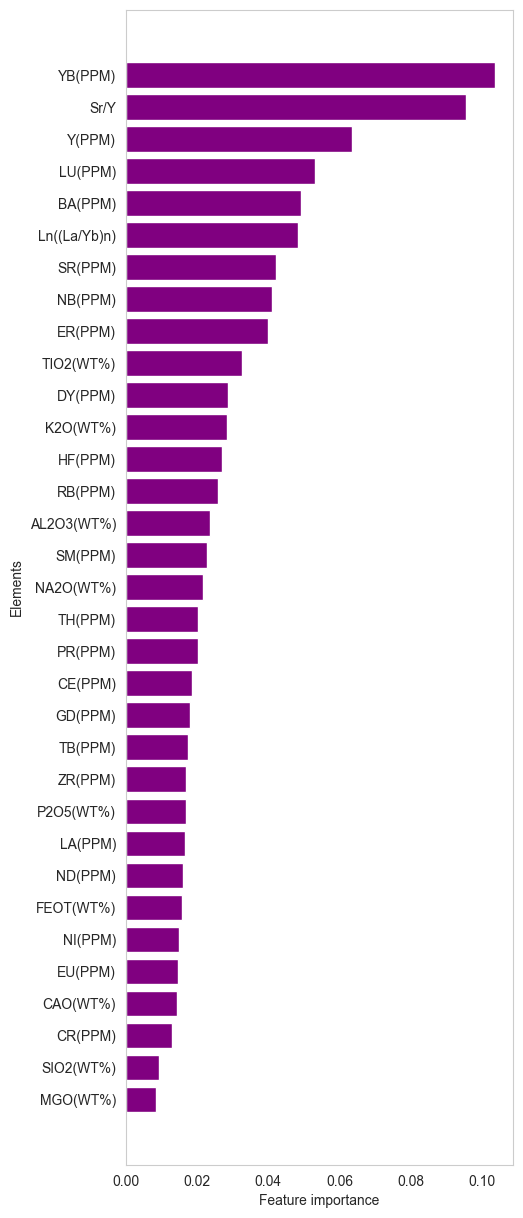

In [32]:
feature_importance = list(rf_reg.feature_importances_[:35])
columns = list(title.columns[:35])
list1, list2 = zip(*sorted(zip(feature_importance, columns)))
plt.figure(figsize=(5, 15))
# 柱状图显示随机森林预测的特征的权重
plt.barh(range(len(list1)), list1, tick_label=list2 , color = 'purple')
#save_fig("rnd_feature_importance")
plt.xlabel('Feature importance')
plt.ylabel('Elements')
plt.grid(False)

The absolute error for the XGBOOST Model : 3.033993082498477
The mean squared error for the XGBOOST Model : 4.72249904549434
The R2-score for the XGBOOST Model : 0.8657244472195839


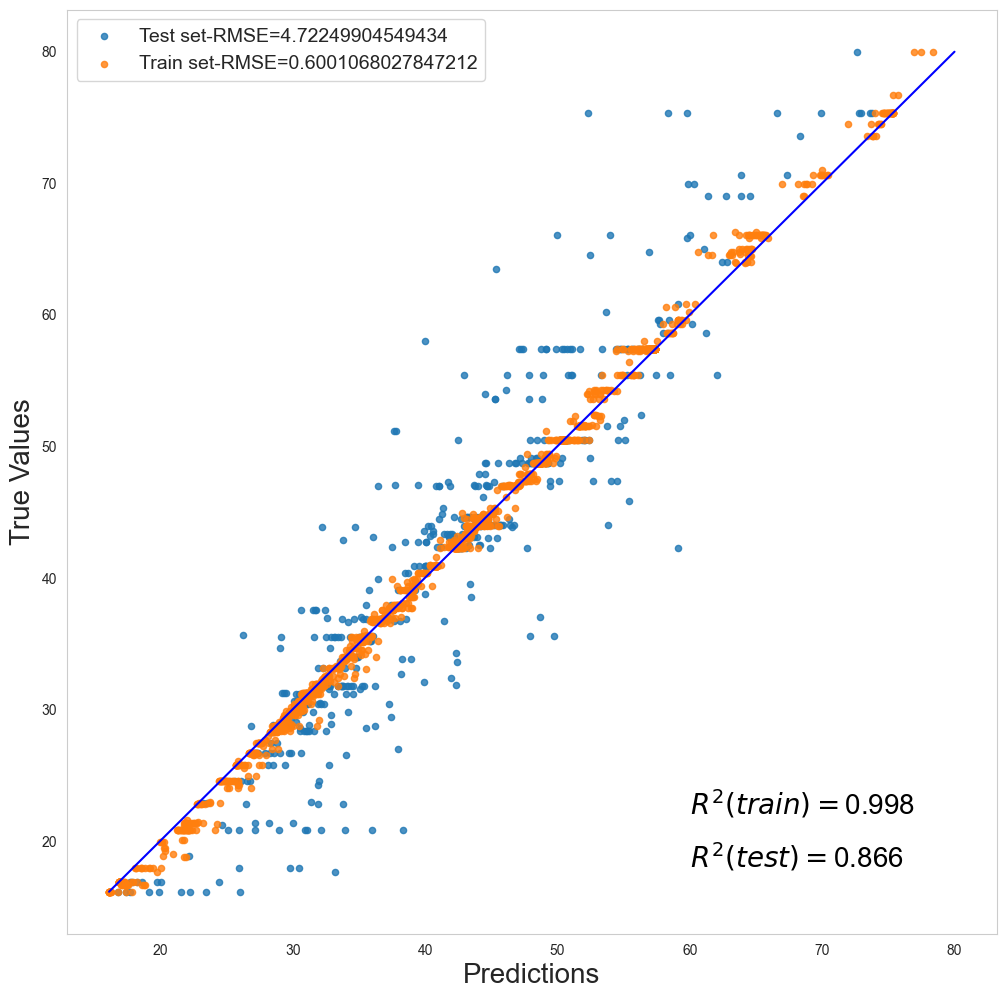

In [33]:
MAE = mean_absolute_error(y_test, y_rf)
MSE = mean_squared_error(y_test, y_rf)
R2_xg = r2_score(y_test, y_rf)
RMSE = np.sqrt(MSE)

MAE2 = mean_absolute_error(y_train, y_rf_train)
MSE2 = mean_squared_error(y_train, y_rf_train)
R2_xg2 = r2_score(y_train, y_rf_train)
RMSE2 = np.sqrt(MSE2)

print("The absolute error for the XGBOOST Model :", MAE)
print("The mean squared error for the XGBOOST Model :", RMSE)
print("The R2-score for the XGBOOST Model :", R2_xg)
plt.figure(figsize = (12,12))
plt.xlabel('True Test Values')
plt.ylabel('Predictions from Model')

p1 = max(max(y_rf), max(y_test))
p2 = min(min(y_rf), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.ylabel('True Values', fontsize=20)
plt.xlabel('Predictions', fontsize=20)
text_position=[60,20]
plt.scatter( y_rf,y_test,marker="o",s = 20,
             label="Test set-RMSE={}".format(RMSE),alpha = 0.8)
plt.scatter( y_rf_train, y_train,marker="o", s = 20,
             label="Train set-RMSE={}".format(RMSE2),alpha = 0.8)
plt.legend(loc="upper left", fontsize=14)
plt.text(text_position[0], text_position[1]-2,
         r'$R^2(test)=${:.3f}'.format(R2_xg),
         fontdict={'size': 20, 'color': '#000000'})
plt.text(text_position[0], text_position[1]+2,
         r'$R^2(train)=${:.3f}'.format(R2_xg2),
         fontdict={'size': 20, 'color': '#000000'})
plt.grid(False)
plt.show()

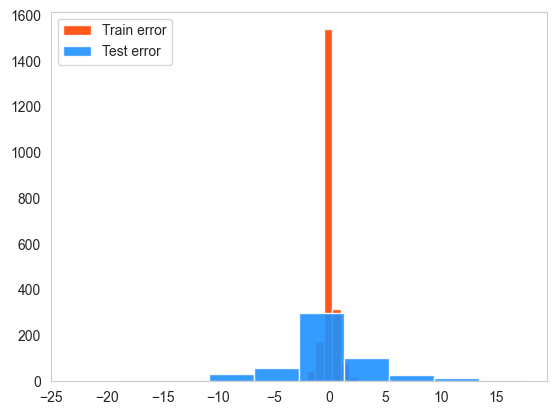

In [34]:
y_train_error_rf = y_rf_train - y_train
y_test_error_rf = y_rf - y_test

plt.hist(y_train_error_rf, bins = 10, color = 'orangered', alpha=.9  , label = 'Train error')
plt.hist(y_test_error_rf, bins = 10, color = 'dodgerblue', alpha=.9 , label = 'Test error')
plt.legend(loc='upper left')
plt.grid(False)
plt.show()

# Extra Tree

In [35]:
from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
grids = {
    'n_estimators': [100,150,200,250,300,350,400,500,600],
    'criterion': ['mse', 'mae'],
    'max_depth': [2,8,16,32,50],
    'max_features': ['auto','sqrt','log2'],
    'bootstrap': [True, False],
    'warm_start': [True, False],
}

extr_optimize = RandomizedSearchCV(model, param_distributions = grids, cv = 10, scoring = 'r2', n_jobs = -1, n_iter = 50, random_state = 100)
extr_optimize.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=ExtraTreesRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse', 'mae'],
                                        'max_depth': [2, 8, 16, 32, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400, 500,
                                                         600],
                                        'warm_start': [True, False]},
                   random_state=100, scoring='r2')

In [36]:
extr_optimize.best_estimator_
model_extr = extr_optimize.best_estimator_


The absolute error for the XGBOOST Model : 2.6708723436551334
The mean squared error for the XGBOOST Model : 4.313729060716611
The R2-score for the XGBOOST Model : 0.8879636582369135


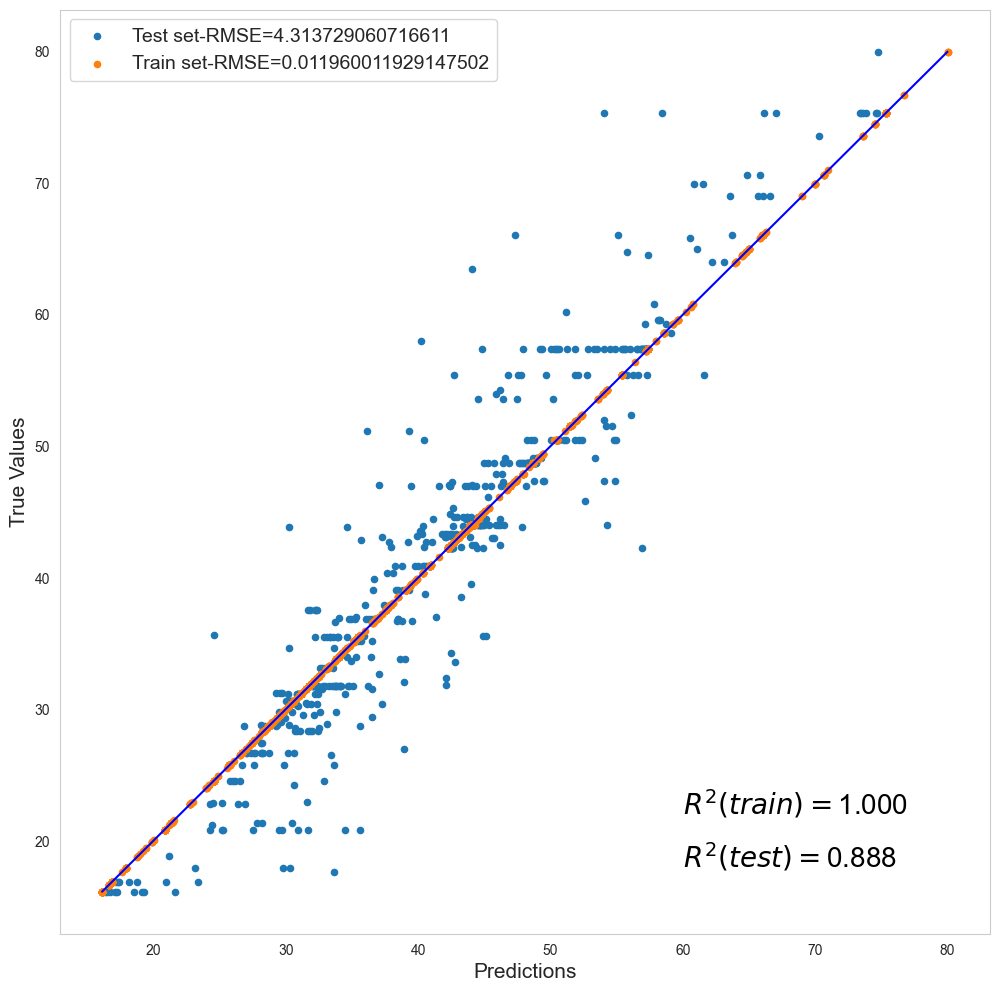

In [37]:
y_extr = model_extr.fit(x_train, y_train).predict(x_test)
y_extr_train = model_extr.fit(x_train, y_train).predict(x_train)
MAE = mean_absolute_error(y_test, y_extr)
MSE = mean_squared_error(y_test, y_extr)
R2_xg = r2_score(y_test, y_extr)
RMSE = np.sqrt(MSE)

MAE2 = mean_absolute_error(y_train, y_extr_train)
MSE2 = mean_squared_error(y_train, y_extr_train)
R2_xg2 = r2_score(y_train, y_extr_train)
RMSE2 = np.sqrt(MSE2)

print("The absolute error for the XGBOOST Model :", MAE)
print("The mean squared error for the XGBOOST Model :", RMSE)
print("The R2-score for the XGBOOST Model :", R2_xg)
plt.figure(figsize=(12, 12))
# plt.scatter(y_test, y_rf, color = 'brown')
# plt.scatter(y_train, y_rf_train, color = 'lightyellow')
plt.xlabel('True Test Values')
plt.ylabel('Predictions from Model')

p1 = max(max(y_extr), max(y_test))
p2 = min(min(y_extr), min(y_test))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.ylabel('True Values', fontsize=15)
plt.xlabel('Predictions', fontsize=15)
text_position = [60, 20]
plt.scatter(y_extr, y_test, marker="o", s=20,
            label="Test set-RMSE={}".format(RMSE))
plt.scatter(y_extr_train, y_train, marker="o",s=20,
            label="Train set-RMSE={}".format(RMSE2))
plt.legend(loc="upper left", fontsize=14)
plt.text(text_position[0], text_position[1] - 2,
         r'$R^2(test)=${:.3f}'.format(R2_xg),
         fontdict={'size': 20, 'color': '#000000'})
plt.text(text_position[0], text_position[1] + 2,
         r'$R^2(train)=${:.3f}'.format(R2_xg2),
         fontdict={'size': 20, 'color': '#000000'})
plt.grid(False)
plt.show()

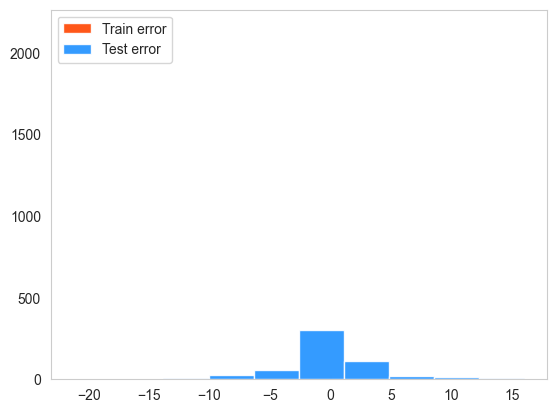

In [38]:
y_train_error_extr = y_extr_train - y_train
y_test_error_extr = y_extr - y_test

plt.hist(y_train_error_extr, bins = 10, color = 'orangered', alpha=.9  , label = 'Train error')
plt.hist(y_test_error_extr, bins = 10, color = 'dodgerblue', alpha=.9 , label = 'Test error')
plt.legend(loc='upper left')
plt.grid(False)
plt.show()

[10:52:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "boost_params" } are not used.



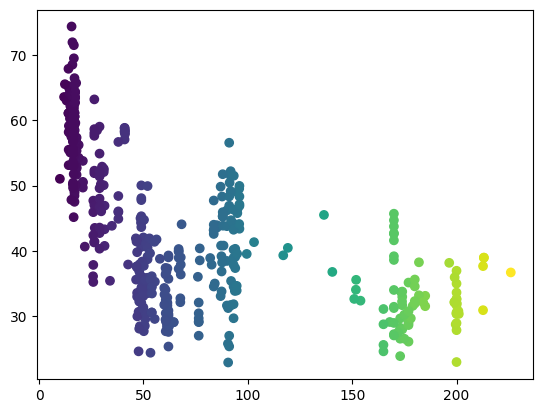

In [56]:
data_G = pd.read_excel("datasets/Gangdese_Datasets.xlsx")
age = data_G['Age']
data  = data_G.drop(['Data source',	'Lat','MnO',	'Long',	'sample',	'Age','Rb/Sr','La/Yb(n)'], axis = 1)

#data.head()
#data2 = data.drop(['Year','CITATION','SAMPLE NAME','ROCK TYPE'], axis=1)
datast = pd.DataFrame(data_process(np.array(data), 3))
data_xgb_total = xgb_reg.fit(X_train, y_train).predict(datast)
data_xgb_total = pd.DataFrame(data_xgb_total)
data_G['crust_thickness'] = data_xgb_total
data_G.to_excel('outputs/Gangdese_application.xlsx')
plt.scatter(age,data_xgb_total ,c=age)